# Jump detection algorithm and Jump height estimation logic

### Import packages 

In [3]:
import pandas as pd 
import csv
import time
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

### Load data 

In [161]:

# def load_clean_csv(path):
#     df = pd.read_csv(path, skiprows=1)
    
#     # Remove rows where 'Timestamp' is not a valid number
#     df = df[pd.to_numeric(df['Timestamp'], errors='coerce').notnull()]
    
#     # Convert to float
#     df['Timestamp'] = df['Timestamp'].astype(float)
    
#     return df.reset_index(drop=True)

#Base path
base_path = '/Users/thomasjohnson/Desktop/Sports Tech/CM2024 - Project course/JumpPro'


# Chest sensor
df_chest_acc  = pd.read_csv(f'{base_path}/Jonatan Chest/Acc-2025_04_04-11_32_45.csv', skiprows=1)
df_chest_gyro = pd.read_csv(f'{base_path}/Jonatan Chest/Gyro-2025_04_04-11_32_45.csv', skiprows=1)
df_chest_mag  = pd.read_csv(f'{base_path}/Jonatan Chest/Magn-2025_04_04-11_32_45.csv', skiprows=1)

# Assimilate df_chest dataframes into one dataframe
df_chest = pd.DataFrame(
    { 'Timestamp': df_chest_acc['Timestamp'],
      'AccX': df_chest_acc['AccX'],
      'AccY': df_chest_acc['AccY'],
      'AccZ': df_chest_acc['AccZ'],
      'GyroX': df_chest_gyro['GyroX'],
      'GyroY': df_chest_gyro['GyroY'],
      'GyroZ': df_chest_gyro['GyroZ'],
      'MagX': df_chest_mag['MagnX'],
      'MagY': df_chest_mag['MagnY'],
      'MagZ': df_chest_mag['MagnZ']
    }
)
# Wrist sensor
df_wrist_acc  = pd.read_csv(f'{base_path}/Jonatan Wrist/Acc-2025_04_04-11_32_45.csv', skiprows=1)
df_wrist_gyro = pd.read_csv(f'{base_path}/Jonatan Wrist/Gyro-2025_04_04-11_32_45.csv', skiprows=1)
df_wrist_mag  = pd.read_csv(f'{base_path}/Jonatan Wrist/Magn-2025_04_04-11_32_45.csv', skiprows=1)

df_wrist = pd.DataFrame(
    { 'Timestamp': df_wrist_acc['Timestamp'],
      'AccX_wrist': df_wrist_acc['AccX'],
      'AccY_wrist': df_wrist_acc['AccY'],
      'AccZ_wrist': df_wrist_acc['AccZ'],
      'GyroX_wrist': df_wrist_gyro['GyroX'],
      'GyroY_wrist': df_wrist_gyro['GyroY'],
      'GyroZ_wrist': df_wrist_gyro['GyroZ'],
      'MagX_wrist': df_wrist_mag['MagnX'],
      'MagY_wrist': df_wrist_mag['MagnY'],
      'MagZ_wrist': df_wrist_mag['MagnZ']
    }
)




In [162]:
df_chest.head()

,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagX,MagY,MagZ
0,1743758128.013,-9.475916,2.962420,0.875804,-1.68,9.24,-3.01,-49.999092,40.282463,-107.336571
1,1743758128.013,-9.499846,3.005492,0.990664,-1.61,10.43,-4.48,-49.099010,39.597252,-107.464066
2,1743758128.013,-9.413700,3.034207,1.028950,-1.26,10.43,-4.41,-49.960094,41.610809,-106.540619
3,1743758128.013,-9.475916,2.981564,1.033736,-0.49,8.82,-4.06,-49.978935,41.606842,-107.101944
4,1743758128.092,-9.423272,2.962420,1.052880,-0.70,7.00,-3.78,-49.922070,37.859406,-109.308662


In [163]:
df_wrist.head()

,Timestamp,AccX_wrist,AccY_wrist,AccZ_wrist,GyroX_wrist,GyroY_wrist,GyroZ_wrist,MagX_wrist,MagY_wrist,MagZ_wrist
0,1743758136.83,4.493881,-3.776009,7.934883,0.91,-1.75,-0.28,62.407127,-103.797234,92.489777
1,1743758136.83,4.603955,-3.752080,7.949241,0.14,-3.64,0.14,59.741192,-99.933456,89.687904
2,1743758136.83,4.536954,-3.723365,7.930098,-0.42,-4.13,0.49,60.905399,-103.841690,89.688240
3,1743758136.83,4.551311,-3.665935,7.901382,-0.63,-3.01,0.63,59.794209,-103.122139,89.683044
4,1743758136.903,4.335949,-3.689864,7.843953,-0.91,-3.36,1.19,59.767700,-101.527802,89.685478


In [164]:
# Align lengths by truncating the longer dataframe
min_len = min(len(df_chest), len(df_wrist))

# Truncate both dataframes to the minimum length
df_chest = df_chest.iloc[:min_len].reset_index(drop=True)
df_wrist = df_wrist.iloc[:min_len].reset_index(drop=True)

# # Add a common time index
# # Ensure timestamps are numeric before converting to datetime
# df_chest['Timestamp'] = pd.to_numeric(df_chest['Timestamp'], errors='coerce')
# df_chest = df_chest.dropna(subset=['Timestamp'])  # drop bad rows
# df_chest['Time'] = pd.to_datetime(df_chest['Timestamp'], unit='ms')

# df_wrist['Timestamp'] = pd.to_numeric(df_wrist['Timestamp'], errors='coerce')
# df_wrist = df_wrist.dropna(subset=['Timestamp'])  # drop bad rows
# df_wrist['Time'] = pd.to_datetime(df_wrist['Timestamp'], unit='ms')

# df_chest.set_index('Time', inplace=True)
# df_wrist.set_index('Time', inplace=True)

# Merge dataframes on the common time index
df_sync = pd.concat([df_chest, df_wrist], axis=1)


In [165]:
df_sync.head(10)

,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagX,MagY,MagZ,Timestamp,AccX_wrist,AccY_wrist,AccZ_wrist,GyroX_wrist,GyroY_wrist,GyroZ_wrist,MagX_wrist,MagY_wrist,MagZ_wrist
0,1743758128.013,-9.475916,2.962420,0.875804,-1.68,9.24,-3.01,-49.999092,40.282463,-107.336571,1743758136.83,4.493881,-3.776009,7.934883,0.91,-1.75,-0.28,62.407127,-103.797234,92.489777
1,1743758128.013,-9.499846,3.005492,0.990664,-1.61,10.43,-4.48,-49.099010,39.597252,-107.464066,1743758136.83,4.603955,-3.752080,7.949241,0.14,-3.64,0.14,59.741192,-99.933456,89.687904
2,1743758128.013,-9.413700,3.034207,1.028950,-1.26,10.43,-4.41,-49.960094,41.610809,-106.540619,1743758136.83,4.536954,-3.723365,7.930098,-0.42,-4.13,0.49,60.905399,-103.841690,89.688240
3,1743758128.013,-9.475916,2.981564,1.033736,-0.49,8.82,-4.06,-49.978935,41.606842,-107.101944,1743758136.83,4.551311,-3.665935,7.901382,-0.63,-3.01,0.63,59.794209,-103.122139,89.683044
4,1743758128.092,-9.423272,2.962420,1.052880,-0.70,7.00,-3.78,-49.922070,37.859406,-109.308662,1743758136.903,4.335949,-3.689864,7.843953,-0.91,-3.36,1.19,59.767700,-101.527802,89.685478
5,1743758128.092,-9.198339,3.048565,1.048094,-2.45,4.76,-2.31,-50.735168,40.923420,-108.479698,1743758136.903,4.489096,-3.555861,7.877453,-1.40,-3.01,0.14,60.914928,-99.319702,91.190697
6,1743758128.092,-9.322770,3.015064,1.024165,-3.01,2.03,-0.70,-51.563717,42.664040,-107.745033,1743758136.903,4.297663,-3.737722,7.858310,-2.03,-2.38,0.14,60.635677,-101.660210,90.917862
7,1743758128.092,-9.241411,3.019850,0.899733,-3.50,2.38,1.19,-51.835297,38.725235,-108.581619,1743758136.903,4.230661,-3.670721,7.877453,-2.87,-3.92,-0.35,62.006390,-101.083763,92.132355
8,1743758128.17,-9.566847,2.675271,0.880590,-1.68,2.31,3.29,-49.932270,41.336884,-106.869736,1743758136.976,4.393379,-3.742508,7.939669,-4.34,-7.77,-0.70,60.224201,-100.269119,90.606468
9,1743758128.17,-9.317985,2.660914,1.005021,5.32,4.20,1.61,-49.021122,37.733944,-107.093964,1743758136.976,4.489096,-3.876511,7.776951,-6.44,-10.36,-2.80,60.224201,-100.269119,90.606468


In [166]:
# Ensure numeric timestamps
df_chest['Timestamp'] = pd.to_numeric(df_chest['Timestamp'], errors='coerce')
df_wrist['Timestamp'] = pd.to_numeric(df_wrist['Timestamp'], errors='coerce')

df_chest.dropna(subset=['Timestamp'], inplace=True)
df_wrist.dropna(subset=['Timestamp'], inplace=True)

# Find wrist start time
wrist_start_time = df_wrist['Timestamp'].iloc[0]

# Trim chest data to start at wrist start time
df_chest_trimmed = df_chest[df_chest['Timestamp'] >= wrist_start_time].copy()

# Trim both dataframes to same length
min_len = min(len(df_chest_trimmed), len(df_wrist))

df_chest_aligned = df_chest_trimmed.iloc[:min_len].reset_index(drop=True)
df_wrist_aligned = df_wrist.iloc[:min_len].reset_index(drop=True)

# Create shared time column starting at t = 0
df_chest_aligned['time'] = (df_chest_aligned['Timestamp'] - wrist_start_time) 
df_wrist_aligned['time'] = (df_wrist_aligned['Timestamp'] - wrist_start_time) 

# Merge for convenience (optional)
df_sync = pd.concat([df_chest_aligned.reset_index(drop=True),
                     df_wrist_aligned.drop(columns=['Timestamp', 'time'])],
                     axis=1)


In [167]:
df_sync.head(10)

,Timestamp,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,MagX,MagY,MagZ,time,AccX_wrist,AccY_wrist,AccZ_wrist,GyroX_wrist,GyroY_wrist,GyroZ_wrist,MagX_wrist,MagY_wrist,MagZ_wrist
0,1.743758e+09,-9.485488,2.876276,0.071787,1.19,6.58,-3.85,-43.433952,35.139660,-90.348404,0.002,4.493881,-3.776009,7.934883,0.91,-1.75,-0.28,62.407127,-103.797234,92.489777
1,1.743758e+09,-9.552489,2.900205,0.057430,1.33,5.67,-3.78,-46.045124,37.415047,-92.310722,0.002,4.603955,-3.752080,7.949241,0.14,-3.64,0.14,59.741192,-99.933456,89.687904
2,1.743758e+09,-9.533346,2.919348,0.062216,-0.28,4.55,-2.59,-43.501209,33.805370,-91.986336,0.002,4.536954,-3.723365,7.930098,-0.42,-4.13,0.49,60.905399,-103.841690,89.688240
3,1.743758e+09,-9.676920,2.943277,0.043072,-1.12,2.45,-1.26,-44.075375,36.561115,-91.353806,0.002,4.551311,-3.665935,7.901382,-0.63,-3.01,0.63,59.794209,-103.122139,89.683044
4,1.743758e+09,-9.533346,2.866704,0.062216,-2.03,1.19,1.40,-44.969860,38.287857,-92.583763,0.081,4.335949,-3.689864,7.843953,-0.91,-3.36,1.19,59.767700,-101.527802,89.685478
5,1.743758e+09,-9.748708,2.866704,-0.009572,-1.54,0.28,3.15,-43.608242,34.622185,-91.700645,0.081,4.489096,-3.555861,7.877453,-1.40,-3.01,0.14,60.914928,-99.319702,91.190697
6,1.743758e+09,-9.676920,2.861918,0.086145,-0.63,1.47,3.36,-43.818031,35.976944,-92.160011,0.081,4.297663,-3.737722,7.858310,-2.03,-2.38,0.14,60.635677,-101.660210,90.917862
7,1.743758e+09,-9.619491,2.909776,0.023929,1.61,2.87,2.59,-43.841152,36.251862,-91.690567,0.081,4.230661,-3.670721,7.877453,-2.87,-3.92,-0.35,62.006390,-101.083763,92.132355
8,1.743758e+09,-9.547704,2.976778,0.038287,2.17,4.48,1.40,-46.114128,34.480465,-94.793068,0.160,4.393379,-3.742508,7.939669,-4.34,-7.77,-0.70,60.224201,-100.269119,90.606468
9,1.743758e+09,-9.614705,2.995921,-0.014357,1.61,3.99,0.28,-45.602753,38.670746,-91.810722,0.160,4.489096,-3.876511,7.776951,-6.44,-10.36,-2.80,60.224201,-100.269119,90.606468


In [168]:
# Estimate sampling frequency
avg_dt = df_sync['time'].diff().dropna().mean()
estimated_hz = 1 / avg_dt
print(f"Estimated sampling rate: {estimated_hz:.2f} Hz")

Estimated sampling rate: 50.80 Hz


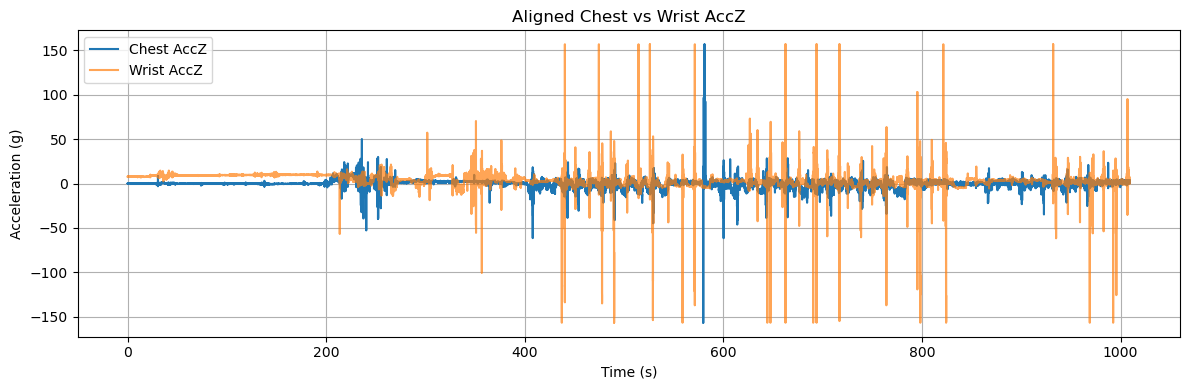

In [169]:
# Check the result
plt.figure(figsize=(12, 4))
plt.plot(df_sync['time'], df_sync['AccZ'], label='Chest AccZ')
plt.plot(df_sync['time'], df_sync['AccZ_wrist'], label='Wrist AccZ', alpha=0.7)
plt.xlabel("Time (s)")
plt.ylabel("Acceleration (g)")
plt.title("Aligned Chest vs Wrist AccZ")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

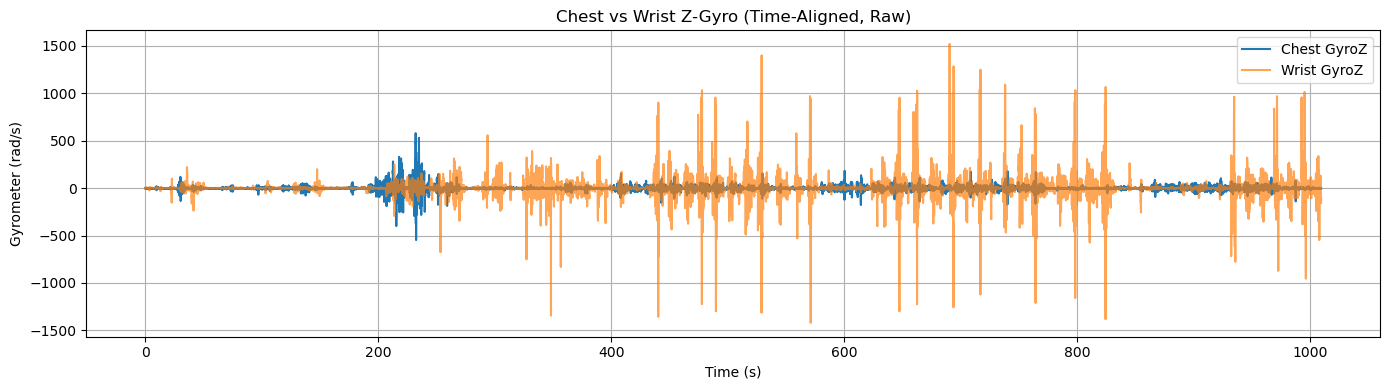

In [170]:
# Visual Sanity Check Gyro
plt.figure(figsize=(14, 4))
plt.plot(df_sync['time'], df_sync['GyroZ'], label='Chest GyroZ')
plt.plot(df_sync['time'], df_sync['GyroZ_wrist'], label='Wrist GyroZ', alpha=0.7) # more transparent
plt.title("Chest vs Wrist Z-Gyro (Time-Aligned, Raw)")
plt.xlabel("Time (s)")
plt.ylabel("Gyrometer (rad/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [171]:
print(df_sync['time'].min(), df_sync['time'].max(), len(df_sync))


0.002000093460083008 1009.3210000991821 51276


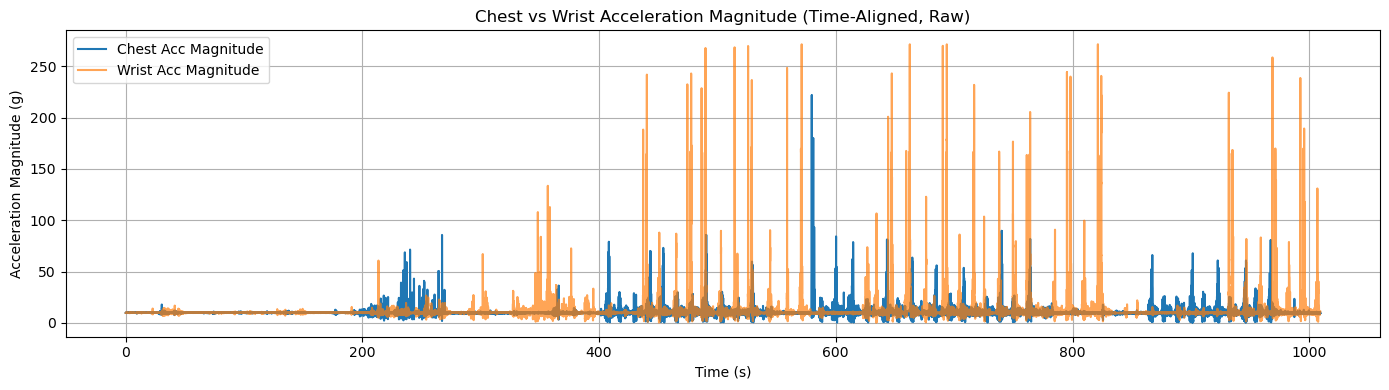

In [172]:
# Sum the x,y,z accelerations to get total acceleration magnitude
df_sync['Acc_Mag'] = np.sqrt(df_sync['AccX']**2 + df_sync['AccY']**2 + df_sync['AccZ']**2)
df_sync['Acc_Mag_wrist'] = np.sqrt(df_sync['AccX_wrist']**2 + df_sync['AccY_wrist']**2 + df_sync['AccZ_wrist']**2)

# Visual Sanity Check Acc Magnitude
plt.figure(figsize=(14, 4))
plt.plot(df_sync['time'], df_sync['Acc_Mag'], label='Chest Acc Magnitude')
plt.plot(df_sync['time'], df_sync['Acc_Mag_wrist'], label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest vs Wrist Acceleration Magnitude (Time-Aligned, Raw)")
plt.xlabel("Time (s)")
plt.ylabel("Acceleration Magnitude (g)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

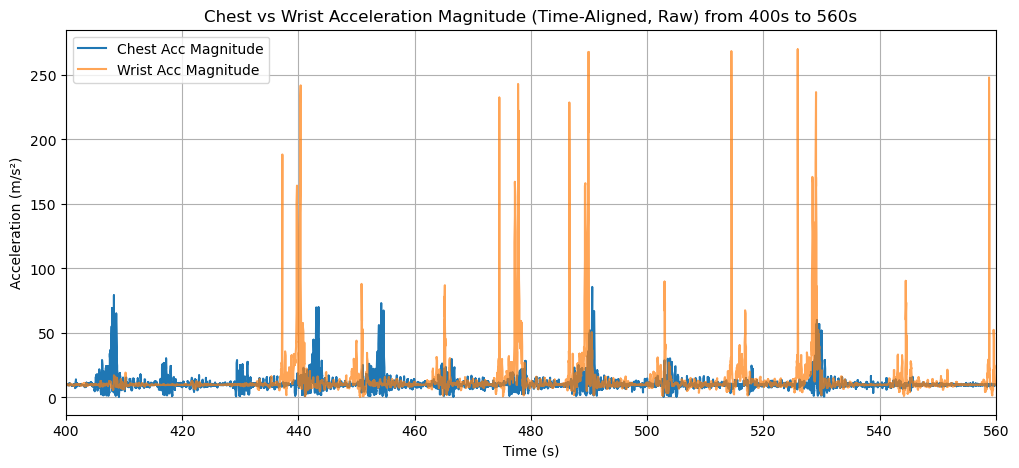

In [173]:
#Plot from 400s to 560s
plt.figure(figsize=(12, 5))
plt.plot(df_sync['time'], df_sync['Acc_Mag'], label='Chest Acc Magnitude')
plt.plot(df_sync['time'], df_sync['Acc_Mag_wrist'], label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest vs Wrist Acceleration Magnitude (Time-Aligned, Raw) from 400s to 560s")
plt.xlim(400, 560)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

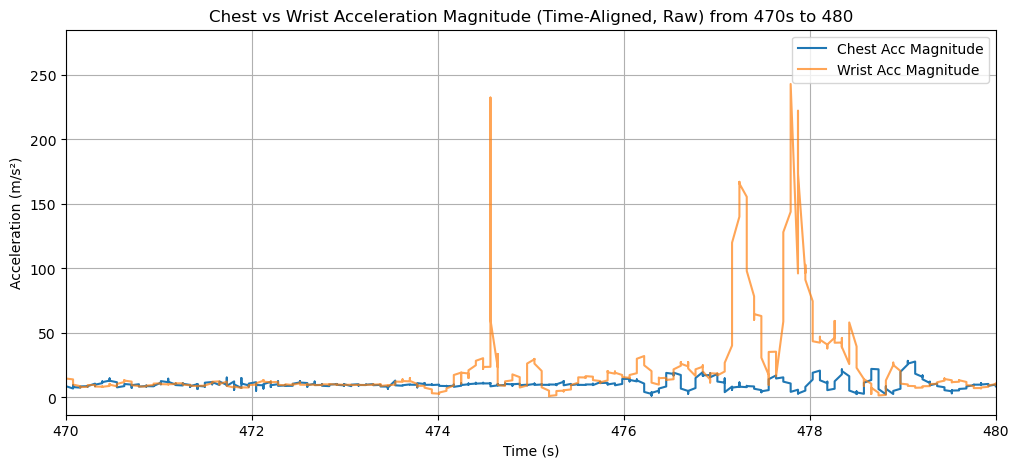

In [174]:
#Plot from 470s to 480s
plt.figure(figsize=(12, 5))
plt.plot(df_sync['time'], df_sync['Acc_Mag'], label='Chest Acc Magnitude')
plt.plot(df_sync['time'], df_sync['Acc_Mag_wrist'], label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest vs Wrist Acceleration Magnitude (Time-Aligned, Raw) from 470s to 480")
plt.xlim(470, 480)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

In [175]:
from scipy.signal import butter, filtfilt

rect_acc_chest = df_sync['Acc_Mag']
rect_acc_wrist = df_sync['Acc_Mag_wrist']

# Low-pass filter setup
def butter_lowpass_filter(data, cutoff=0.5, fs=50, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_acc_chest = butter_lowpass_filter(rect_acc_chest, cutoff=0.5, fs=estimated_hz)
filtered_acc_wrist = butter_lowpass_filter(rect_acc_wrist, cutoff=0.5, fs=estimated_hz)

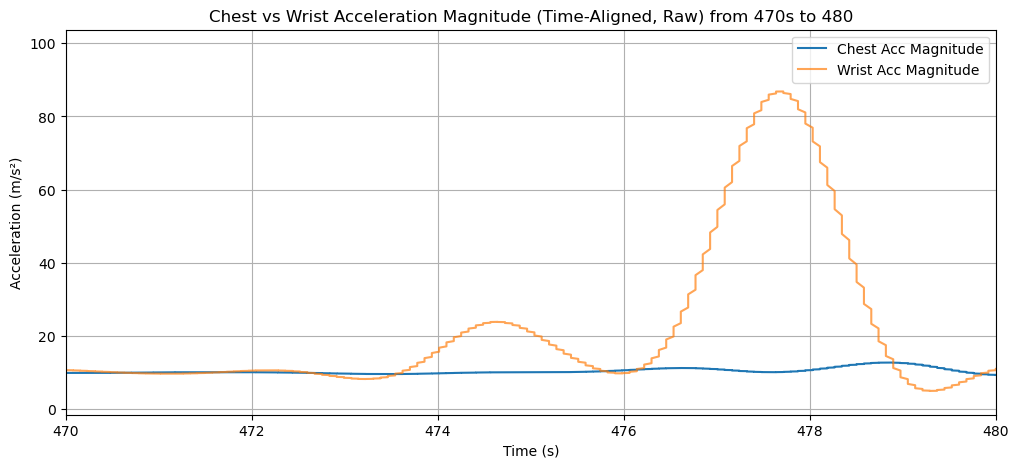

In [176]:
#Plot from 470s to 480s
plt.figure(figsize=(12, 5))
plt.plot(df_sync['time'], filtered_acc_chest, label='Chest Acc Magnitude')
plt.plot(df_sync['time'], filtered_acc_wrist, label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest vs Wrist Acceleration Magnitude (Time-Aligned, Raw) from 470s to 480")
plt.xlim(470, 480)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

In [177]:
df_sync.to_csv('synchronized_data.csv', index=False)

### Madgwick filter - imufusion

In [212]:

import imufusion

# # read back in synchronized data as df_sync
# df_sync = pd.read_csv('synchronized_data.csv')

# # Prepare data for processing
timestamp = df_sync['time'].to_numpy()  # seconds
# gyroscope_s = df_sync[['GyroX', 'GyroY', 'GyroZ']].to_numpy()
# accelerometer = df_sync[['AccX', 'AccY', 'AccZ']].to_numpy()
# magnetometer = df_sync[['MagX', 'MagY', 'MagZ']].to_numpy()
gyroscope_s   = df_sync[["GyroX_wrist","GyroY_wrist","GyroZ_wrist"]].to_numpy()  # rad/s
accelerometer = df_sync[["AccX_wrist","AccY_wrist","AccZ_wrist"]].to_numpy()     # g
magnetometer  = df_sync[["MagX_wrist","MagY_wrist","MagZ_wrist"]].to_numpy()     # uT 

# Sampling and delta time
dt = np.diff(timestamp, prepend=timestamp[0])
median_dt = np.median(dt[dt > 0])
dt[dt <= 0] = median_dt

# Replace any zeros/negatives just in case of edge effects
# Estimate sampling rate
time_diffs = df_sync['time'].diff().dropna()
avg_dt = time_diffs.mean()           # average dt (seconds)
sample_rate_est = 1 / avg_dt         # Hz

print(f"Estimated sample rate: {sample_rate_est:.2f} Hz")

# Explicit cast to Python int
offset = imufusion.Offset(int(round(sample_rate_est)))
ahrs = imufusion.Ahrs()
ahrs.settings = imufusion.Settings(
    imufusion.CONVENTION_NWU,  # frame convention
    0.5,                       # gain
    2000,                      # gyro range (deg/s)
    10,                        # accel rejection
    10,                        # mag rejection
    int(5 * sample_rate_est),  # recovery trigger period in samples (~5 s)
)

# Preallocate outputs
n = len(timestamp)
euler_deg       = np.empty((n, 3))
gyro_global     = np.empty_like(gyroscope_s)
accel_global    = np.empty_like(accelerometer)
mag_global      = np.empty_like(magnetometer)
flags           = np.empty((n, 4), dtype=int)
internal_states = np.empty((n, 6))

# Run filter + rotate to global frame each step
for i in range(n):
    gyroscope_s[i] = offset.update(gyroscope_s[i])
    ahrs.update(gyroscope_s[i], accelerometer[i], magnetometer[i], dt[i])

    # Rotation matrix from body → global
    R = ahrs.quaternion.to_matrix()

    # Rotate signals
    gyro_global[i]  = R @ gyroscope_s[i]
    accel_global[i] = R @ accelerometer[i]
    mag_global[i]   = R @ magnetometer[i]

    # Euler
    euler_deg[i] = ahrs.quaternion.to_euler() 

    # Optional diagnostics
    ist = ahrs.internal_states
    internal_states[i] = np.array([
        ist.acceleration_error,
        ist.accelerometer_ignored,
        ist.acceleration_recovery_trigger,
        ist.magnetic_error,
        ist.magnetometer_ignored,
        ist.magnetic_recovery_trigger,
    ])
    fl = ahrs.flags
    flags[i] = np.array([fl.initialising, fl.angular_rate_recovery, fl.acceleration_recovery, fl.magnetic_recovery])

# Build output DataFrame
df_madgwick = pd.DataFrame({
    "time": timestamp,
    
    # # Euler angles chest
    # "roll_deg_chest":  euler_deg[:,0],
    # "pitch_deg_chest": euler_deg[:,1],
    # "yaw_deg_chest":   euler_deg[:,2],
    # # Global-frame chest signals
    # "GyroX_chest_global": gyro_global[:,0],
    # "GyroY_chest_global": gyro_global[:,1],
    # "GyroZ_chest_global": gyro_global[:,2],
    # "AccX_chest_global":  accel_global[:,0],
    # "AccY_chest_global":  accel_global[:,1],
    # "AccZ_chest_global":  accel_global[:,2],
    # "MagX_chest_global":  mag_global[:,0],
    # "MagY_chest_global":  mag_global[:,1],
    # "MagZ_chest_global":  mag_global[:,2],

    # Euler angles wrist
    "roll_deg_wrist":  euler_deg[:,0],
    "pitch_deg_wrist": euler_deg[:,1],
    "yaw_deg_wrist":   euler_deg[:,2],
    # Global-frame wrist signals
    "GyroX_wrist_global": gyro_global[:,0],
    "GyroY_wrist_global": gyro_global[:,1],
    "GyroZ_wrist_global": gyro_global[:,2],
    "AccX_wrist_global":  accel_global[:,0],
    "AccY_wrist_global":  accel_global[:,1],
    "AccZ_wrist_global":  accel_global[:,2],
    "MagX_wrist_global":  mag_global[:,0],
    "MagY_wrist_global":  mag_global[:,1],
    "MagZ_wrist_global":  mag_global[:,2],

    # # Flags 
    # "flag_initialising":          flags[:,0],
    # "flag_angrate_recovery":      flags[:,1],
    # "flag_accel_recovery":        flags[:,2],
    # "flag_magnetic_recovery":     flags[:,3],
    # "accel_err_deg":              internal_states[:,0],
    # "accel_ignored":              internal_states[:,1],
    # "accel_recovery_trigger":     internal_states[:,2],
    # "mag_err_deg":                internal_states[:,3],
    # "mag_ignored":                internal_states[:,4],
    # "mag_recovery_trigger":       internal_states[:,5],
})



Estimated sample rate: 50.80 Hz


In [213]:
print(dt)

[0.079 0.079 0.079 ... 0.079 0.079 0.079]


In [214]:
print(time_diffs)

1        0.000
2        0.000
3        0.000
4        0.079
5        0.000
         ...  
51271    0.000
51272    0.078
51273    0.000
51274    0.000
51275    0.000
Name: time, Length: 51275, dtype: float64


In [215]:
sample_rate_est

np.float64(50.80158007499048)

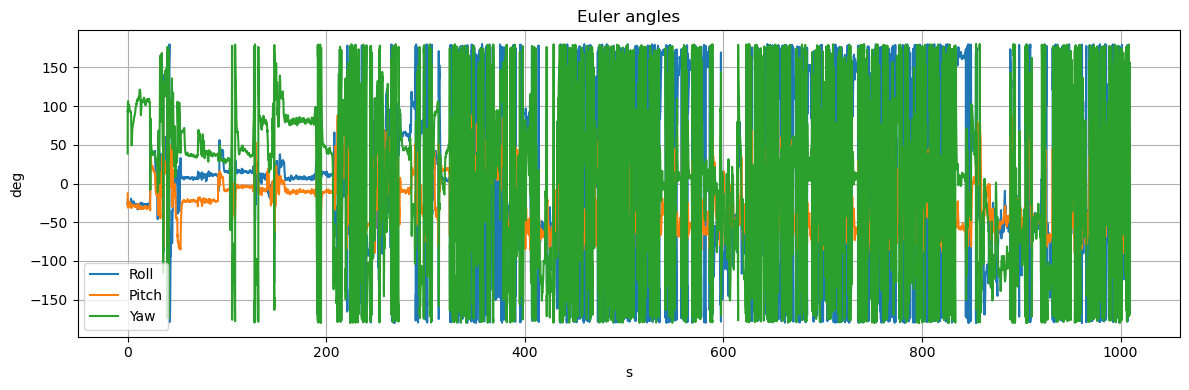

In [216]:
# Quick sanity plot
plt.figure(figsize=(12,4))
# plt.plot(df_madgwick["time"], df_madgwick["roll_deg_chest"],  label="Roll")
# plt.plot(df_madgwick["time"], df_madgwick["pitch_deg_chest"], label="Pitch")
# plt.plot(df_madgwick["time"], df_madgwick["yaw_deg_chest"],   label="Yaw")
plt.plot(df_madgwick["time"], df_madgwick["roll_deg_wrist"],  label="Roll")
plt.plot(df_madgwick["time"], df_madgwick["pitch_deg_wrist"], label="Pitch")
plt.plot(df_madgwick["time"], df_madgwick["yaw_deg_wrist"],   label="Yaw")

plt.ylabel("deg"); plt.xlabel("s"); plt.title("Euler angles"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()


0.0 0.07900023460399552 0.01968404321721121


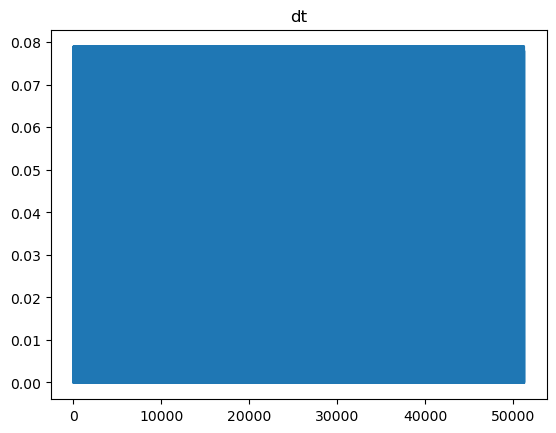

In [217]:
dt = np.diff(timestamp, prepend=timestamp[0])
print(dt.min(), dt.max(), dt.mean())
plt.plot(dt); plt.title('dt'); plt.show()


In [218]:
df_madgwick.head()

,time,roll_deg_wrist,pitch_deg_wrist,yaw_deg_wrist,GyroX_wrist_global,GyroY_wrist_global,GyroZ_wrist_global,AccX_wrist_global,AccY_wrist_global,AccZ_wrist_global,MagX_wrist_global,MagY_wrist_global,MagZ_wrist_global
0,0.002,-21.212173,-12.748998,38.908428,1.715048,-0.842458,0.563805,2.313529,1.033120,9.539174,65.866333,-28.182966,134.499903
1,0.002,-25.868296,-23.354166,57.434448,2.412273,-2.194426,1.629182,0.321921,0.675269,9.894713,45.802611,-22.642287,137.800869
2,0.002,-26.042542,-26.543859,76.042702,3.058820,-2.185064,1.828254,-0.097489,0.172808,9.863796,51.871888,-14.848632,140.090569
3,0.002,-25.465237,-27.533260,87.697731,2.387679,-1.516977,1.360760,-0.087076,0.013057,9.827388,54.301985,-7.090678,138.757263
4,0.081,-25.427614,-27.071232,92.828369,2.617003,-1.829062,1.827465,-0.031349,-0.085720,9.691997,53.291339,-0.852659,138.140724


In [219]:
## Save for reuse
# df_madgwick.to_csv("df_madgwick_jonatan_chest.csv", index=False)
df_madgwick.to_csv("df_madgwick_jonatan_wrist.csv", index=False)
# df_madgwick.to_csv("df_madgwick_david_c.csv", index=False)
# df_madgwick.to_csv("df_madgwick_david_w.csv", index=False)

## Jump detection algorithm analysis

### Import post-madgwick

In [220]:


df_mad_jonatan_wrist = pd.read_csv('df_madgwick_jonatan_wrist.csv')
df_mad_jonatan_chest = pd.read_csv('df_madgwick_jonatan_chest.csv')

#Load df_sync 
df_sync = pd.read_csv('synchronized_data.csv')

### Plotting

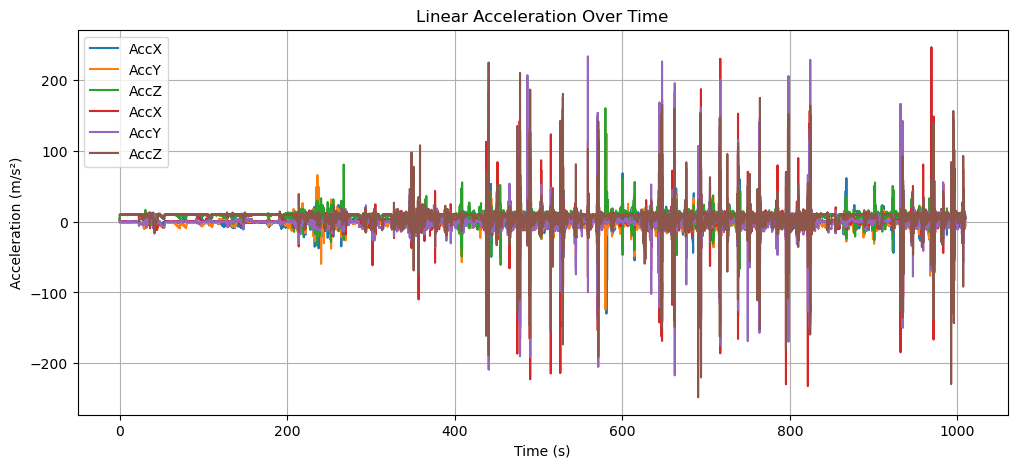

In [221]:
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccX_chest_global'], label='AccX')
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccY_chest_global'], label='AccY')
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccZ_chest_global'], label='AccZ')
plt.plot(df_mad_jonatan_wrist['time'], df_mad_jonatan_wrist['AccX_wrist_global'], label='AccX')
plt.plot(df_mad_jonatan_wrist['time'], df_mad_jonatan_wrist['AccY_wrist_global'], label='AccY')
plt.plot(df_mad_jonatan_wrist['time'], df_mad_jonatan_wrist['AccZ_wrist_global'], label='AccZ')
plt.title('Linear Acceleration Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()


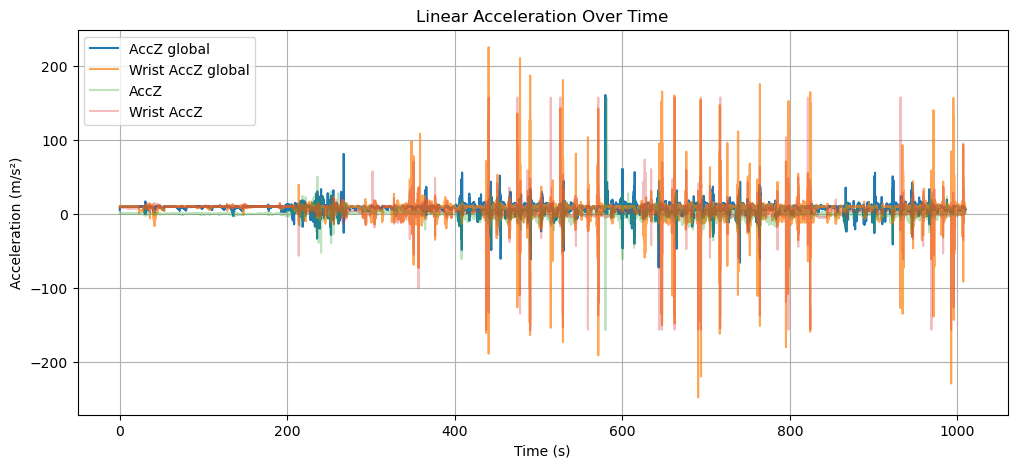

In [223]:
#Compare Madgwick and raw vertical acceleration
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccZ_chest_global'], label='AccZ global')
plt.plot(df_mad_jonatan_wrist['time'], df_mad_jonatan_wrist['AccZ_wrist_global'], label='Wrist AccZ global', alpha=0.7)
plt.plot(df_sync['time'], df_sync['AccZ'], label='AccZ', alpha=0.3)
plt.plot(df_sync['time'], df_sync['AccZ_wrist'], label='Wrist AccZ', alpha=0.3)
plt.title('Linear Acceleration Over Time')
# plt.xlim(400, 560)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

### Gyro

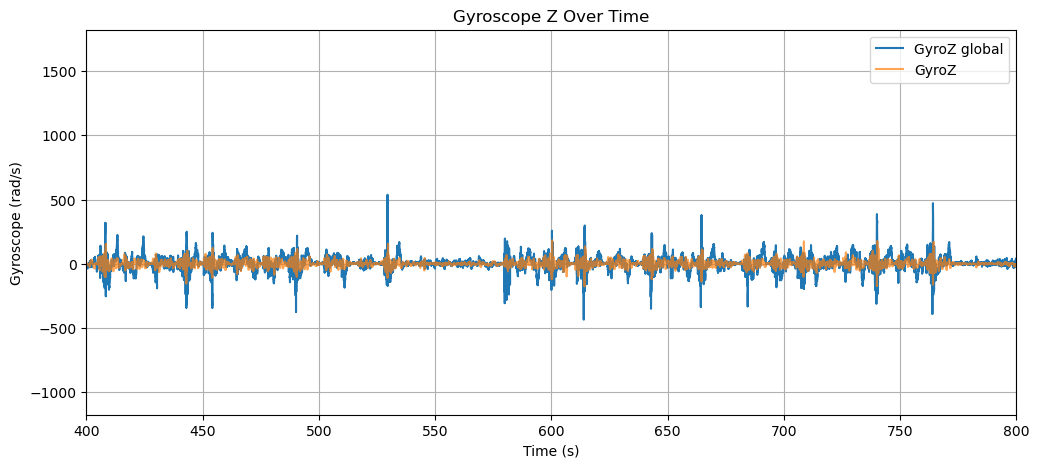

In [225]:
# Compare Madgwick and raw gyro Z with Madgwick Z-gyro
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['GyroZ_chest_global'], label='GyroZ global')
plt.plot(df_sync['time'], df_sync['GyroZ'], label='GyroZ', alpha=0.7)
plt.title('Gyroscope Z Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Gyroscope (rad/s)')   
plt.xlim(400, 800)  # Adjust x-axis limits to zoom in  
plt.legend()
plt.grid(True)
plt.show()

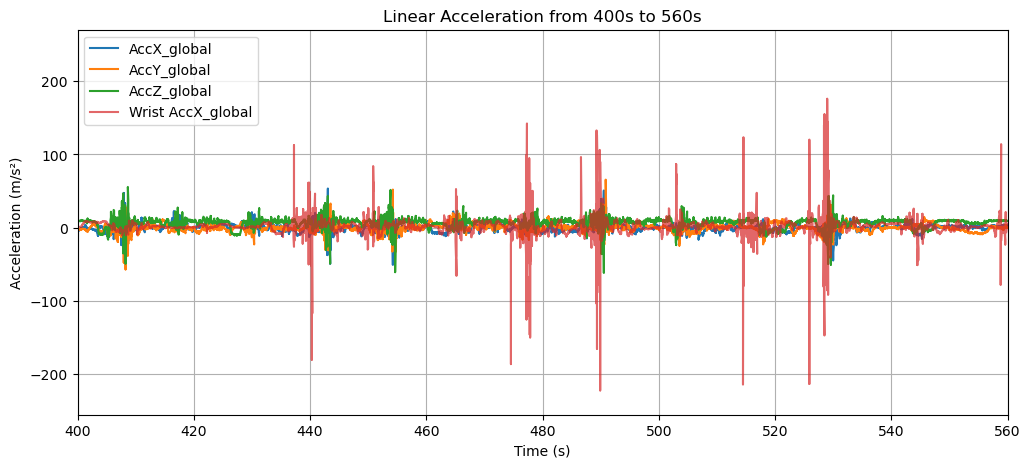

In [227]:
#Plot from 400s to 560s
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccX_chest_global'], label='AccX_global')
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccY_chest_global'], label='AccY_global')
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccZ_chest_global'], label='AccZ_global')
plt.plot(df_mad_jonatan_wrist['time'], df_mad_jonatan_wrist['AccX_wrist_global'], label='Wrist AccX_global', alpha=0.7)
plt.xlim(400, 560)  # Adjust x-axis limits to zoom in
# plt.ylim(-500, 500)  # Adjust y-axis limits if needed
plt.title('Linear Acceleration from 400s to 560s')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

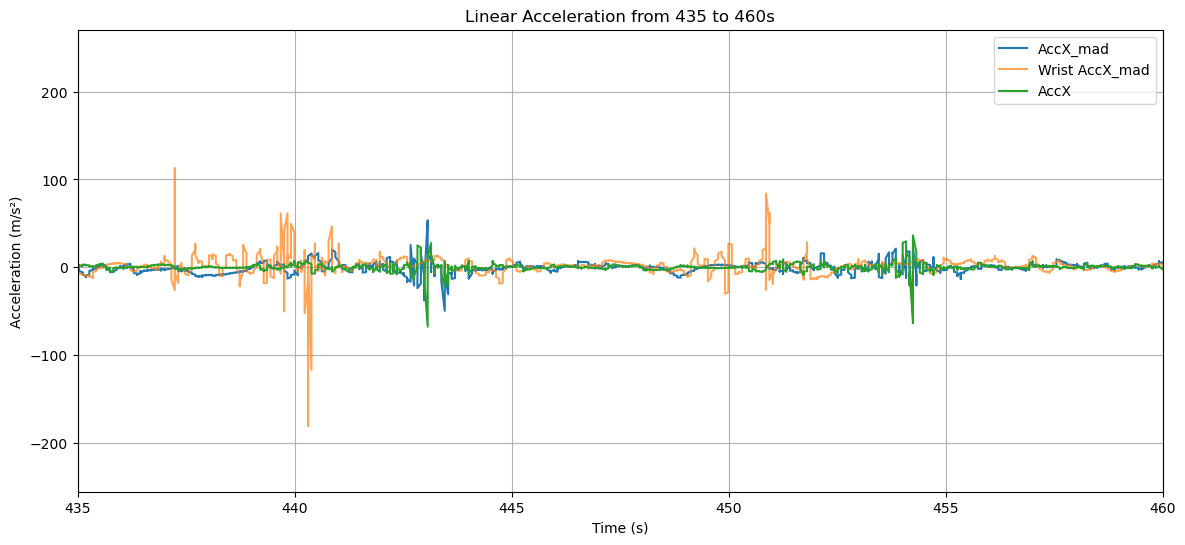

In [228]:
#Plot from 435s to 460s
plt.figure(figsize=(14, 6))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['AccX_chest_global'], label='AccX_mad')
plt.plot(df_mad_jonatan_wrist['time'], df_mad_jonatan_wrist['AccX_wrist_global'], label='Wrist AccX_mad', alpha=0.7)
plt.plot(df_sync['time'], df_sync['AccX'], label='AccX')
plt.xlim(435, 460)  # Adjust x-axis limits to zoom in
# plt.ylim(-500, 500)  # Adjust y-axis limits 
plt.title('Linear Acceleration from 435 to 460s')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

### Filtering

In [229]:
from scipy.signal import butter, filtfilt

# Low-pass filter setup
def butter_lowpass_filter(data, cutoff=1, fs=50, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='low', analog=False)
    return filtfilt(b, a, data)

filtered_accX_ch = butter_lowpass_filter(df_mad_jonatan_chest['AccX_chest_global'])
filtered_accY_ch = butter_lowpass_filter(df_mad_jonatan_chest['AccY_chest_global'])
filtered_accZ_ch = butter_lowpass_filter(df_mad_jonatan_chest['AccZ_chest_global']) # convert to g
filtered_accX_wr = butter_lowpass_filter(df_mad_jonatan_wrist['AccX_wrist_global'])
filtered_accY_wr = butter_lowpass_filter(df_mad_jonatan_wrist['AccY_wrist_global'])
filtered_accZ_wr = butter_lowpass_filter(df_mad_jonatan_wrist['AccZ_wrist_global'])

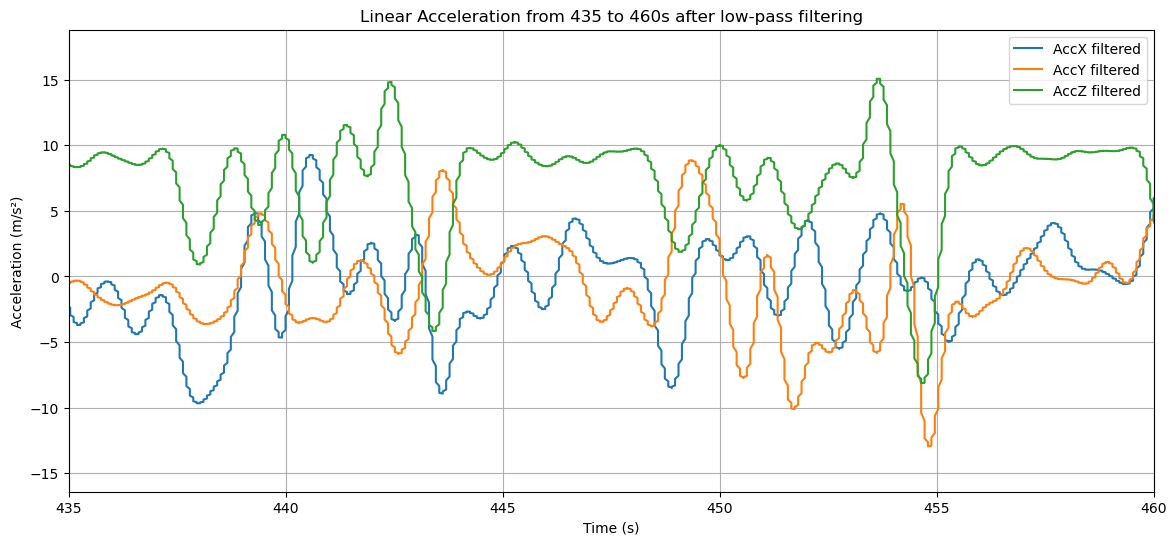

In [230]:
#Plot from 435s to 460s
plt.figure(figsize=(14, 6))
plt.plot(df_mad_jonatan_chest['time'], filtered_accX_ch, label='AccX filtered')
plt.plot(df_mad_jonatan_chest['time'], filtered_accY_ch, label='AccY filtered')
plt.plot(df_mad_jonatan_chest['time'], filtered_accZ_ch, label='AccZ filtered')
plt.xlim(435, 460)  # Adjust x-axis limits to zoom in
# plt.ylim(-500, 500)  # Adjust y-axis limits 
plt.title('Linear Acceleration from 435 to 460s after low-pass filtering')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s²)')
plt.legend()
plt.grid(True)
plt.show()

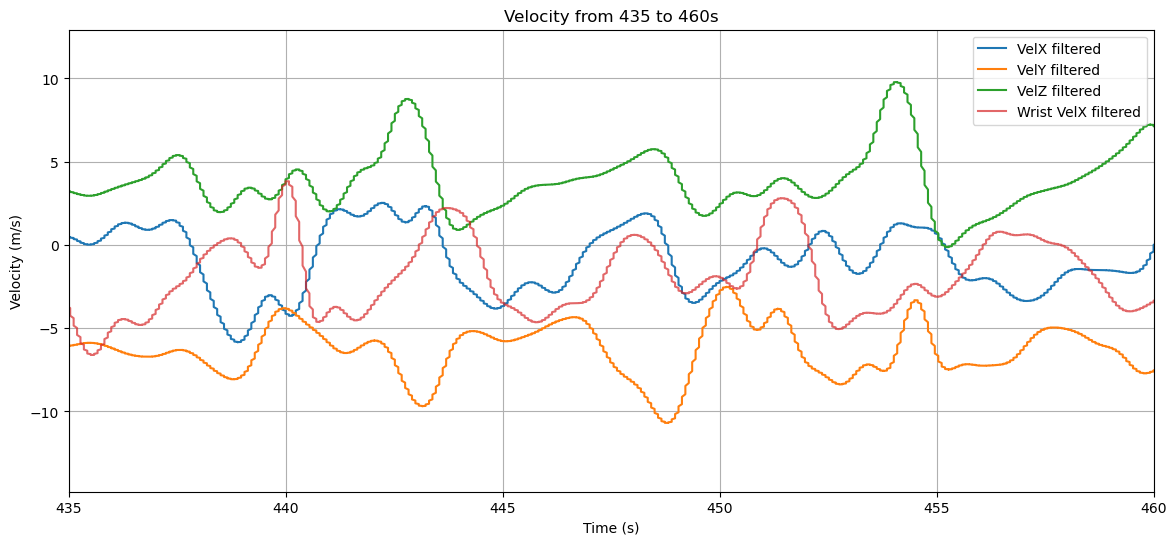

In [233]:
from scipy import integrate

def butter_highpass_filter(data, cutoff=0.1, fs=50, order=4):
    nyq = 0.5 * fs
    norm_cutoff = cutoff / nyq
    b, a = butter(order, norm_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)

filtered_accX_ch = butter_highpass_filter(filtered_accX_ch, cutoff=0.1, fs=estimated_hz)
filtered_accY_ch = butter_highpass_filter(filtered_accY_ch, cutoff=0.1, fs=estimated_hz)
filtered_accZ_ch = butter_highpass_filter(filtered_accZ_ch, cutoff=0.1, fs=estimated_hz)
filtered_accX_wr = butter_highpass_filter(filtered_accX_wr, cutoff=0.1, fs=estimated_hz)
filtered_accY_wr = butter_highpass_filter(filtered_accY_wr, cutoff=0.1, fs=estimated_hz)
filtered_accZ_wr = butter_highpass_filter(filtered_accZ_wr, cutoff=0.1, fs=estimated_hz)

# Example for velocity
filtered_velX_ch = integrate.cumulative_trapezoid(filtered_accX_ch, dx=1/estimated_hz, initial=0)
filtered_velY_ch = integrate.cumulative_trapezoid(filtered_accY_ch, dx=1/estimated_hz, initial=0)
filtered_velZ_ch = integrate.cumulative_trapezoid(filtered_accZ_ch, dx=1/estimated_hz, initial=0)

filtered_velX_wr = integrate.cumulative_trapezoid(filtered_accX_wr, dx=1/estimated_hz, initial=0)
filtered_velY_wr = integrate.cumulative_trapezoid(filtered_accY_wr, dx=1/estimated_hz, initial=0)
filtered_velZ_wr = integrate.cumulative_trapezoid(filtered_accZ_wr, dx=1/estimated_hz, initial=0)

#Plot from 435s to 460s
plt.figure(figsize=(14, 6))
plt.plot(df_mad_jonatan_chest['time'], filtered_velX_ch, label='VelX filtered')
plt.plot(df_mad_jonatan_chest['time'], filtered_velY_ch, label='VelY filtered')
plt.plot(df_mad_jonatan_chest['time'], filtered_velZ_ch, label='VelZ filtered')
plt.plot(df_mad_jonatan_wrist['time'], filtered_velX_wr, label='Wrist VelX filtered', alpha=0.7)
plt.xlim(435, 460)  # Adjust x-axis limits to zoom in
# plt.ylim(-500, 500)  # Adjust y-axis limits 
plt.title('Velocity from 435 to 460s')
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

### Clean

In [68]:
# print(np.isnan(df_mad_jonatan_chest['AccZ_chest_global']).sum(), np.isnan(df_mad_jonatan_chest['AccY_chest_global']).sum(), np.isnan(df_mad_jonatan_chest['AccX_chest_global']).sum())

In [69]:
# # Drop rows with any NaN in AccX, AccY, or AccZ
# # df_clean = df.dropna(subset=['AccX', 'AccY', 'AccZ'])
# df_clean = df.dropna(subset=['AccX_global', 'AccY_global', 'AccZ_global'])

In [234]:
# Now extract the cleaned arrays and convert to #convert m/s^2 to g using the post-madgwick data
acc_x_chest = df_mad_jonatan_chest['AccX_chest_global'].values/9.81
acc_y_chest = df_mad_jonatan_chest['AccY_chest_global'].values/9.81
acc_z_chest = df_mad_jonatan_chest['AccZ_chest_global'].values/9.81
acc_x_wrist = df_mad_jonatan_wrist['AccX_wrist_global'].values/9.81
acc_y_wrist = df_mad_jonatan_wrist['AccY_wrist_global'].values/9.81
acc_z_wrist = df_mad_jonatan_wrist['AccZ_wrist_global'].values/9.81

### Sum the acceleration

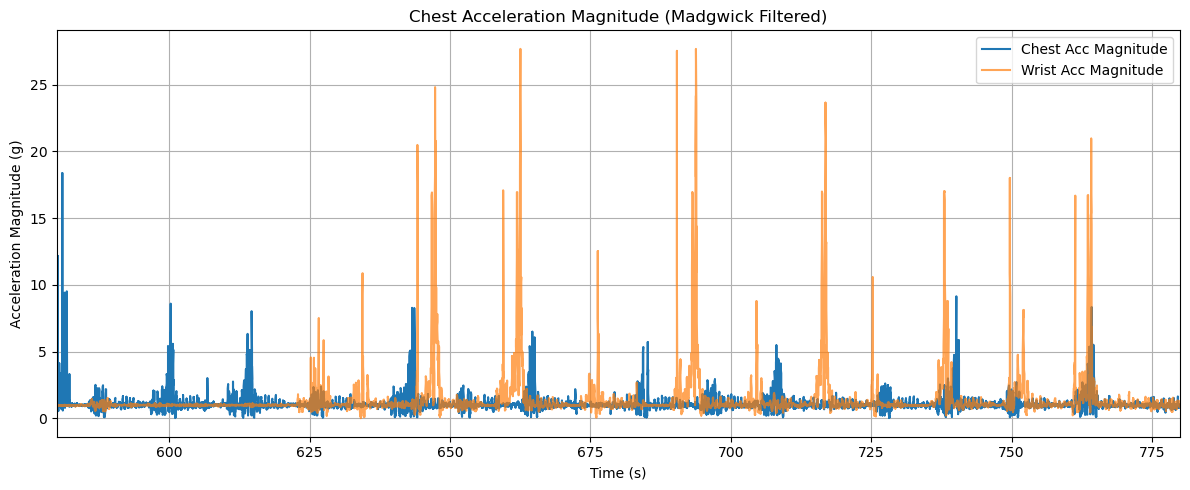

In [235]:
# Rectify acceleration by summing the squares of each axis and taking the square root
df_mad_jonatan_chest['Acc_Mag_chest'] = np.sqrt(acc_x_chest**2 + acc_y_chest**2 + acc_z_chest**2)
df_mad_jonatan_wrist['Acc_Mag_wrist'] = np.sqrt(acc_x_wrist**2 + acc_y_wrist**2 + acc_z_wrist**2)

# Plot the rectified acceleration
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], df_mad_jonatan_chest['Acc_Mag_chest'], label='Chest Acc Magnitude')
plt.plot(df_mad_jonatan_wrist['time'], df_mad_jonatan_wrist['Acc_Mag_wrist'], label='Wrist Acc Magnitude', alpha=0.7) #       more transparent
plt.title("Chest Acceleration Magnitude (Madgwick Filtered)")
plt.xlim(580, 780)  # Adjust x-axis limits to zoom in
plt.xlabel("Time (s)")
plt.ylabel("Acceleration Magnitude (g)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

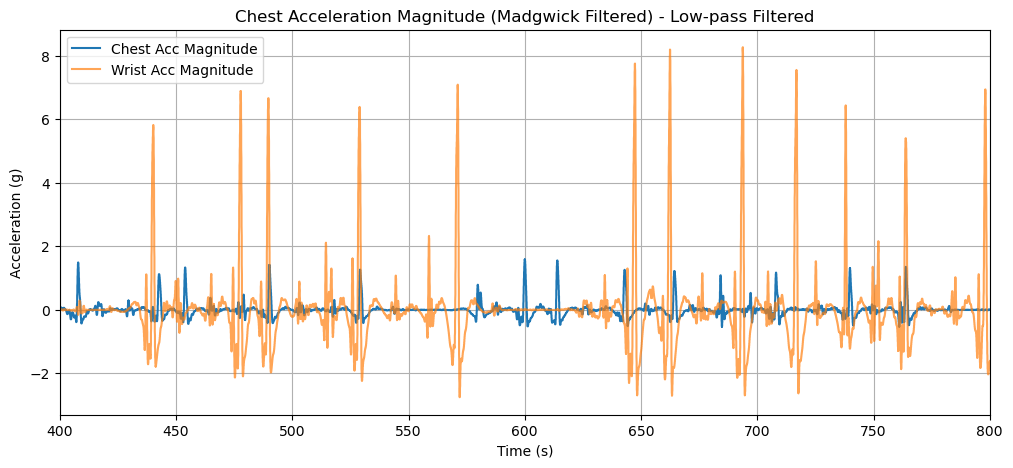

In [238]:
# Low-pass filter the rectified acceleration
filtered_acc_ch = butter_lowpass_filter(df_mad_jonatan_chest['Acc_Mag_chest'], cutoff=1, fs=estimated_hz)
filtered_acc_wr = butter_lowpass_filter(df_mad_jonatan_wrist['Acc_Mag_wrist'] , cutoff=1, fs=estimated_hz)

# High-pass filter the rectified acceleration to remove drift
filtered_acc_ch = butter_highpass_filter(filtered_acc_ch, cutoff=0.1, fs=estimated_hz)
filtered_acc_wr = butter_highpass_filter(filtered_acc_wr, cutoff=0.1, fs=estimated_hz)

#Plot
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], filtered_acc_ch, label='Chest Acc Magnitude')
plt.plot(df_mad_jonatan_wrist['time'], filtered_acc_wr, label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest Acceleration Magnitude (Madgwick Filtered) - Low-pass Filtered")
plt.xlim(400, 800)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)
plt.show()

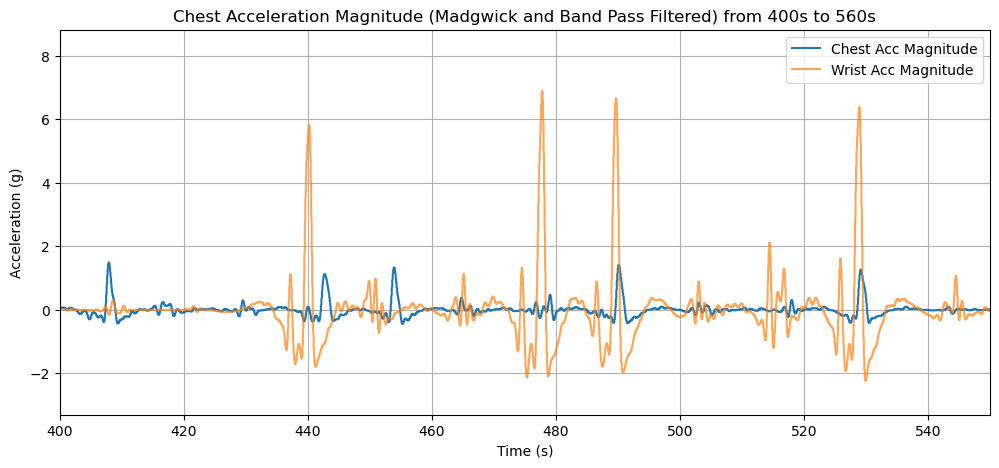

In [239]:
#Plot from 400s to 550s
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], filtered_acc_ch, label='Chest Acc Magnitude')
plt.plot(df_mad_jonatan_wrist['time'], filtered_acc_wr, label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest Acceleration Magnitude (Madgwick and Band Pass Filtered) from 400s to 560s")
plt.xlim(400, 550)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)
plt.show()

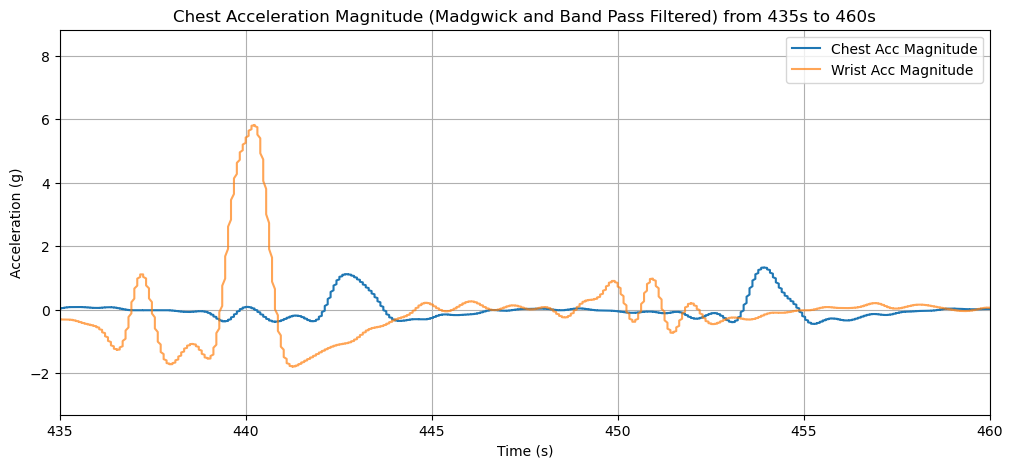

In [240]:
#Plot from 435s to 460s
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], filtered_acc_ch, label='Chest Acc Magnitude')
plt.plot(df_mad_jonatan_wrist['time'], filtered_acc_wr, label='Wrist Acc Magnitude', alpha=0.7) # more transparent
plt.title("Chest Acceleration Magnitude (Madgwick and Band Pass Filtered) from 435s to 460s")
plt.xlim(435, 460)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (g)')
plt.legend()
plt.grid(True)
plt.show()

### Trapezoidal integration for velocity

In [241]:
# Trapezoidal integration to get velocity
vel_ch = integrate.cumulative_trapezoid(filtered_acc_ch, dx=1/estimated_hz, initial=0)
vel_wr = integrate.cumulative_trapezoid(filtered_acc_wr, dx=1/estimated_hz, initial=0)

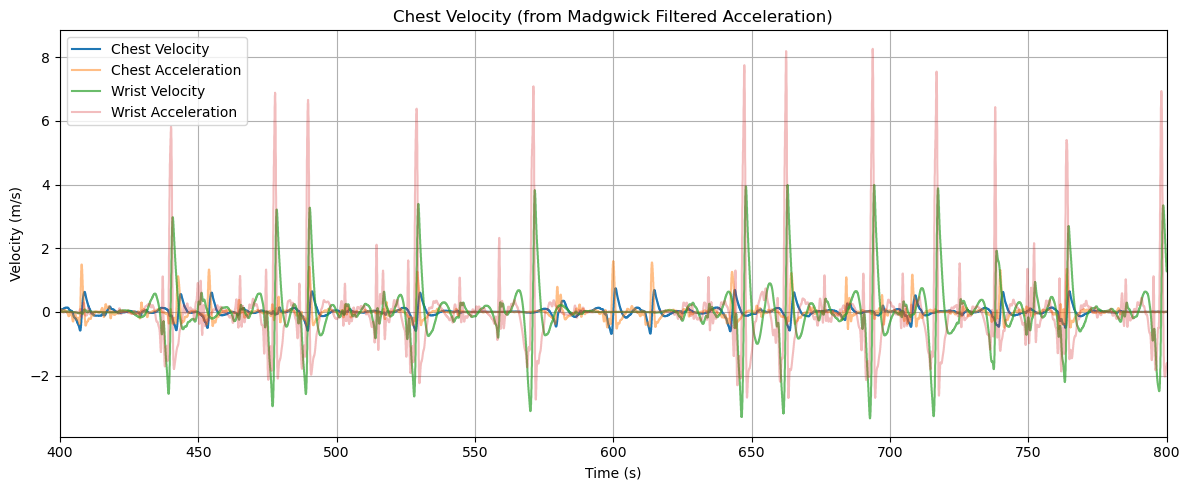

In [242]:

# Plot the velocity
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], vel_ch, label='Chest Velocity')
plt.plot(df_mad_jonatan_chest['time'], filtered_acc_ch, label='Chest Acceleration', alpha=0.5)
plt.plot(df_mad_jonatan_wrist['time'], vel_wr, label='Wrist Velocity', alpha=0.7) # more transparent
plt.plot(df_mad_jonatan_wrist['time'], filtered_acc_wr, label='Wrist Acceleration', alpha=0.3) # more transparent
plt.title("Chest Velocity (from Madgwick Filtered Acceleration)")
plt.xlim(400, 800)  # Adjust x-axis limits to zoom in
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

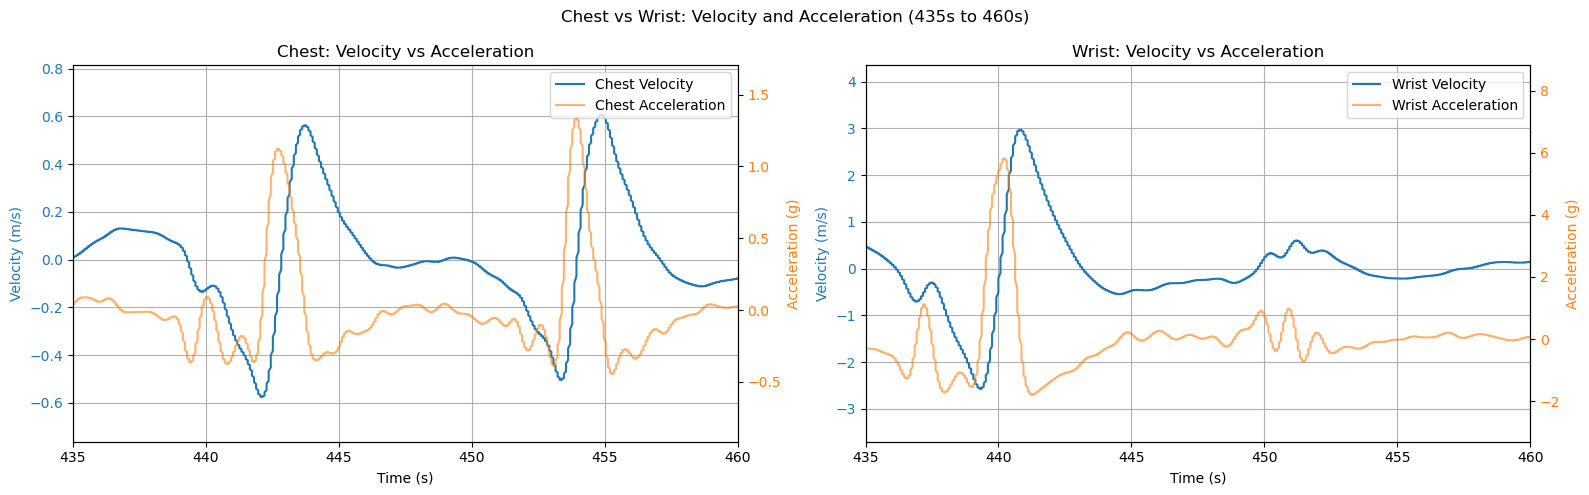

In [243]:
# Plot velocity and acceleration for Chest and Wrist
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(16, 5), sharex=True)

# Chest subplot
ax1.plot(df_mad_jonatan_chest['time'], vel_ch, color="tab:blue", label='Chest Velocity')
ax1.set_xlim(435, 460)
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("Velocity (m/s)", color="tab:blue")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(df_mad_jonatan_chest['time'], filtered_acc_ch,
         color="tab:orange", alpha=0.6, label='Chest Acceleration')
ax2.set_ylabel("Acceleration (g)", color="tab:orange")
ax2.tick_params(axis='y', labelcolor="tab:orange")

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")
ax1.set_title("Chest: Velocity vs Acceleration")

# Wrist subplot 
ax3.plot(df_mad_jonatan_wrist['time'], vel_wr, color="tab:blue", label='Wrist Velocity')
ax3.set_xlim(435, 460)
ax3.set_xlabel("Time (s)")
ax3.set_ylabel("Velocity (m/s)", color="tab:blue")
ax3.tick_params(axis='y', labelcolor="tab:blue")
ax3.grid(True)

ax4 = ax3.twinx()
ax4.plot(df_mad_jonatan_wrist['time'], filtered_acc_wr,
         color="tab:orange", alpha=0.6, label='Wrist Acceleration')
ax4.set_ylabel("Acceleration (g)", color="tab:orange")
ax4.tick_params(axis='y', labelcolor="tab:orange")

lines_3, labels_3 = ax3.get_legend_handles_labels()
lines_4, labels_4 = ax4.get_legend_handles_labels()
ax3.legend(lines_3 + lines_4, labels_3 + labels_4, loc="upper right")
ax3.set_title("Wrist: Velocity vs Acceleration")

plt.suptitle("Chest vs Wrist: Velocity and Acceleration (435s to 460s)")
plt.tight_layout()
plt.show()



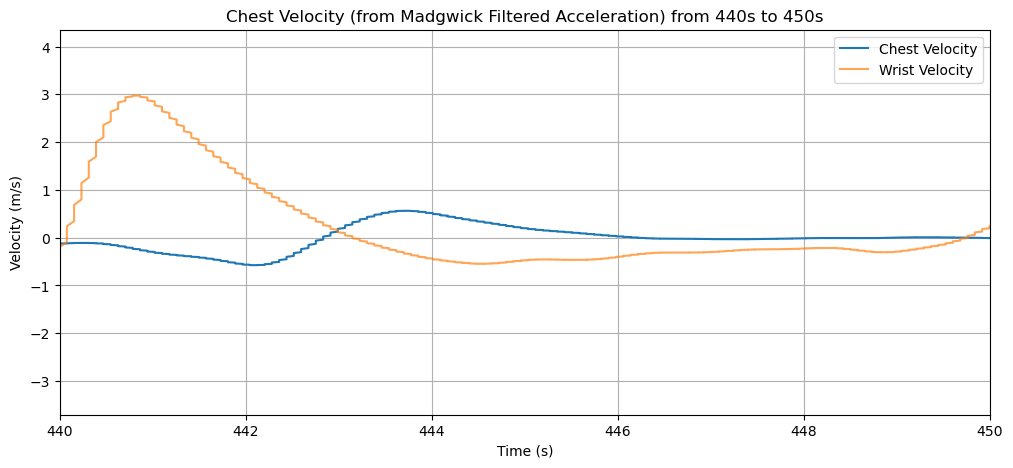

In [244]:
#Plot from 440s to 450s
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], vel_ch, label='Chest Velocity')
plt.plot(df_mad_jonatan_wrist['time'], vel_wr, label='Wrist Velocity', alpha=0.7) # more transparent
plt.title("Chest Velocity (from Madgwick Filtered Acceleration) from 440s to 450s")
plt.xlim(440, 450)  # Adjust x-axis limits to zoom in
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.grid(True)
plt.show()

### Zero velocity update

[Chest] ZUPT applied – 188 stance samples reset
[Wrist] ZUPT applied – 226 stance samples reset


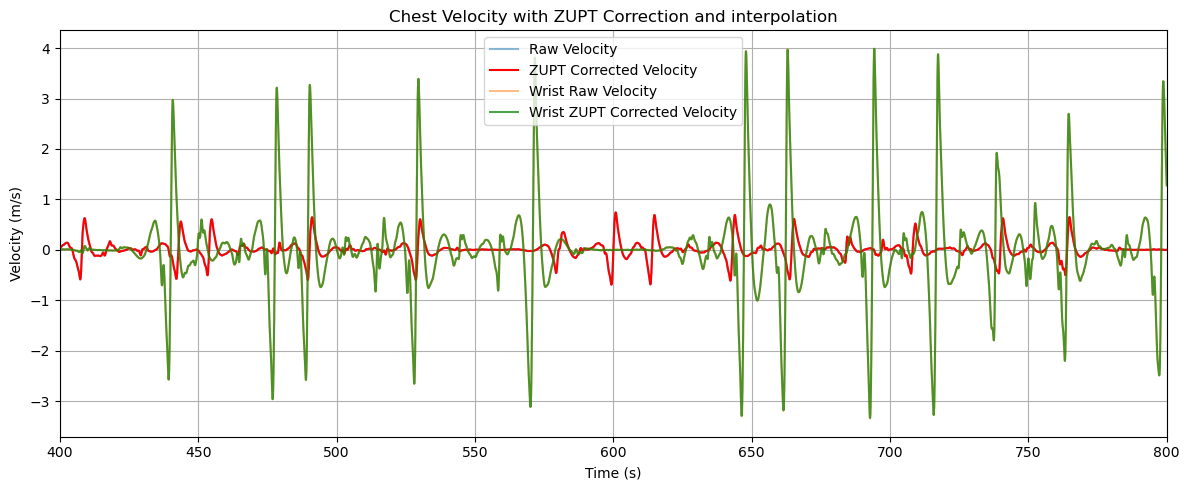

In [253]:
# Zero-Velocity Update (ZUPT) Implementation
from scipy.interpolate import interp1d

def apply_zupt(accel_mag, velocity, time, sensor_name="", stance_range=(0.90, 1.10)):
    """    
    Parameters
    ----------
    accel_mag : array-like
        Magnitude of acceleration signal (in g).
    velocity : array-like
        Integrated velocity signal (same length as accel_mag).
    time : array-like
        Time array (in seconds).
    sensor_name : str, optional
        For printing/debugging (e.g. 'Chest' or 'Wrist').
    stance_range : tuple
        Min and max g values considered as 'stance' (default: 0.90–1.10 g).
    
    Returns
    -------
    vel_corrected : np.ndarray
        Velocity with ZUPT applied.
    stance : np.ndarray (bool)
        Boolean mask of stance points.
    """

    # Detect stance
    stance = pd.Series(accel_mag).between(stance_range[0], stance_range[1]).to_numpy()

    # Apply ZUPT
    vel_corrected = velocity.copy()
    vel_corrected[stance] = 0.0

    # Interpolate across stance zones to smooth transitions
    not_stance = ~stance
    interp_func = interp1d(
        time[not_stance],
        vel_corrected[not_stance],
        bounds_error=False,
        fill_value="extrapolate",
    )
    vel_corrected = interp_func(time)

    if sensor_name:
        print(f"[{sensor_name}] ZUPT applied – {stance.sum()} stance samples reset")

    return vel_corrected, stance


# Apply ZUPT to both chest and wrist velocities
vel_corrected_ch, stance_ch = apply_zupt(filtered_acc_ch, vel_ch, df_mad_jonatan_chest['time'].values, sensor_name="Chest")
vel_corrected_wr, stance_wr = apply_zupt(filtered_acc_wr, vel_wr, df_mad_jonatan_wrist['time'].values, sensor_name="Wrist")



# Plot the corrected velocity
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], vel_ch, label='Raw Velocity', alpha=0.5)
plt.plot(df_mad_jonatan_chest['time'], vel_corrected_ch, label='ZUPT Corrected Velocity', color='red')
plt.plot(df_mad_jonatan_wrist['time'], vel_wr, label='Wrist Raw Velocity', alpha=0.5)
plt.plot(df_mad_jonatan_wrist['time'], vel_corrected_wr, label='Wrist ZUPT Corrected Velocity', color='green', alpha=0.7) 
plt.title("Chest Velocity with ZUPT Correction and interpolation")
plt.xlim(400, 800)  # Adjust x-axis limits to zoom in
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


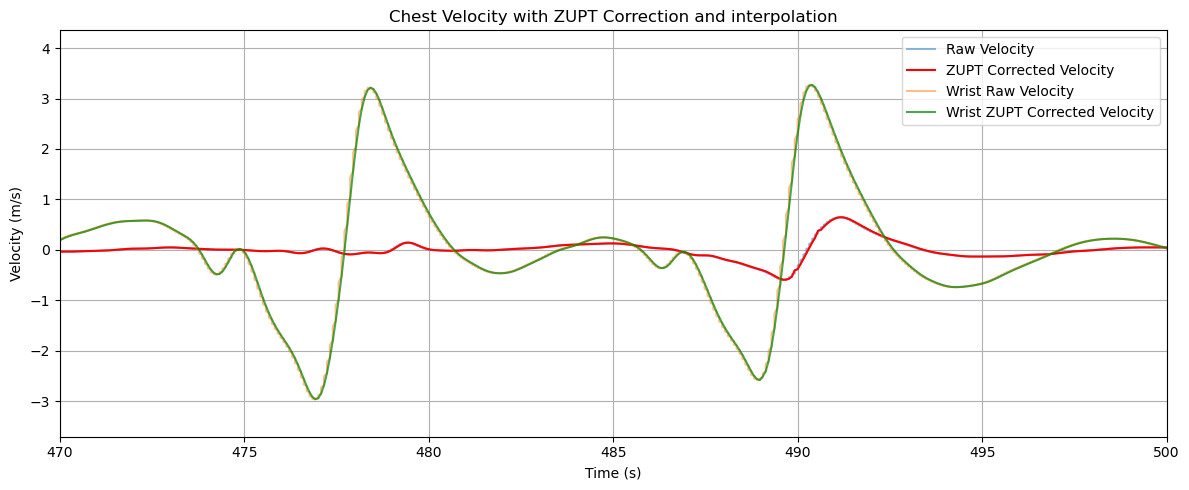

In [254]:
# Plot the corrected velocity
plt.figure(figsize=(12, 5))
plt.plot(df_mad_jonatan_chest['time'], vel_ch, label='Raw Velocity', alpha=0.5)
plt.plot(df_mad_jonatan_chest['time'], vel_corrected_ch, label='ZUPT Corrected Velocity', color='red')
plt.plot(df_mad_jonatan_wrist['time'], vel_wr, label='Wrist Raw Velocity', alpha=0.5)
plt.plot(df_mad_jonatan_wrist['time'], vel_corrected_wr, label='Wrist ZUPT Corrected Velocity', color='green', alpha=0.7) 
plt.title("Chest Velocity with ZUPT Correction and interpolation")
plt.xlim(470, 500)  # Adjust x-axis limits to zoom in
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Find peaks

[Chest] Detected 28 landings and 22 takeoffs.


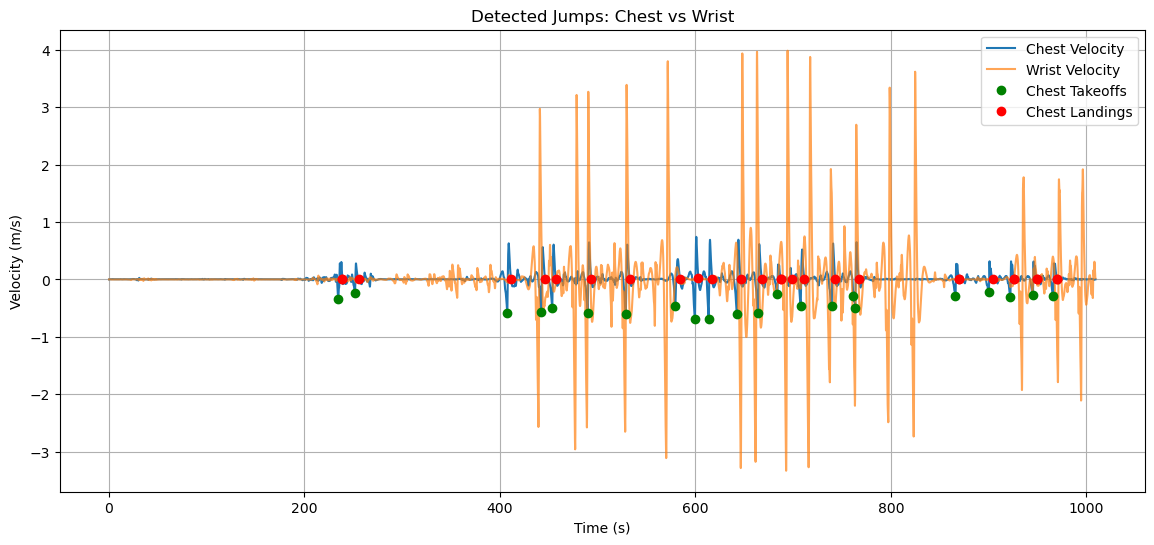

In [260]:
from scipy.signal import find_peaks

def detect_jumps(vel_signal, sensor_name, pos_height=0.2, neg_height=0.2, distance=50):
    """
    Detect jump takeoffs (negative peaks) and landings (positive peaks + zero-crossing after).
    Returns dict with indices for takeoffs and landings.
    """
    # Detect peaks
    peaks_positive, _ = find_peaks(vel_signal, height=pos_height, distance=distance)
    peaks_negative, _ = find_peaks(-vel_signal, height=neg_height, distance=distance)

    # Find first zero-crossing after each landing peak
    landing_indices = []
    for peak in peaks_positive:
        zero_crossings = np.where(np.diff(np.sign(vel_signal[peak:]))) [0]
        if len(zero_crossings) > 0:
            landing_idx = peak + zero_crossings[0]
            landing_indices.append(landing_idx)

    print(f"[{sensor_name}] Detected {len(landing_indices)} landings and {len(peaks_negative)} takeoffs.")

    return {
        "takeoffs": peaks_negative,
        "mid-jump": peaks_positive,
        "landings": landing_indices,
    }

# Apply to chest sensor
chest_jumps = detect_jumps(vel_corrected_ch, "Chest")

# plotting overlay
plt.figure(figsize=(14,6))
plt.plot(df_mad_jonatan_chest['time'], vel_corrected_ch, label="Chest Velocity")
plt.plot(df_mad_jonatan_wrist['time'], vel_corrected_wr, label="Wrist Velocity", alpha=0.7)

plt.plot(df_mad_jonatan_chest['time'].iloc[chest_jumps["takeoffs"]], 
         vel_corrected_ch[chest_jumps["takeoffs"]], "go", label="Chest Takeoffs")
plt.plot(df_mad_jonatan_chest['time'].iloc[chest_jumps["landings"]], 
         vel_corrected_ch[chest_jumps["landings"]], "ro", label="Chest Landings")

plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.title("Detected Jumps: Chest vs Wrist")
plt.show()


In [261]:
chest_jumps

{'takeoffs': array([11913, 12773, 20697, 22461, 23033, 24877, 26857, 29433, 30449,
        31165, 32633, 33721, 34737, 35949, 37561, 38685, 38781, 43993,
        45729, 46845, 48017, 49073]),
 'mid-jump': array([12001, 12077, 12837, 20777, 22545, 23109, 24953, 26937, 29565,
        30525, 31237, 32713, 33801, 34781, 34833, 35433, 36029, 37637,
        38857, 44037, 44089, 45769, 46885, 46941, 48057, 48113, 49113,
        49169]),
 'landings': [np.int64(12131),
  np.int64(12131),
  np.int64(12999),
  np.int64(20895),
  np.int64(22671),
  np.int64(23223),
  np.int64(25067),
  np.int64(27059),
  np.int64(29675),
  np.int64(30635),
  np.int64(31355),
  np.int64(32835),
  np.int64(33927),
  np.int64(34927),
  np.int64(34927),
  np.int64(35527),
  np.int64(36151),
  np.int64(37747),
  np.int64(38967),
  np.int64(44195),
  np.int64(44195),
  np.int64(45935),
  np.int64(47043),
  np.int64(47043),
  np.int64(48231),
  np.int64(48231),
  np.int64(49271),
  np.int64(49271)]}

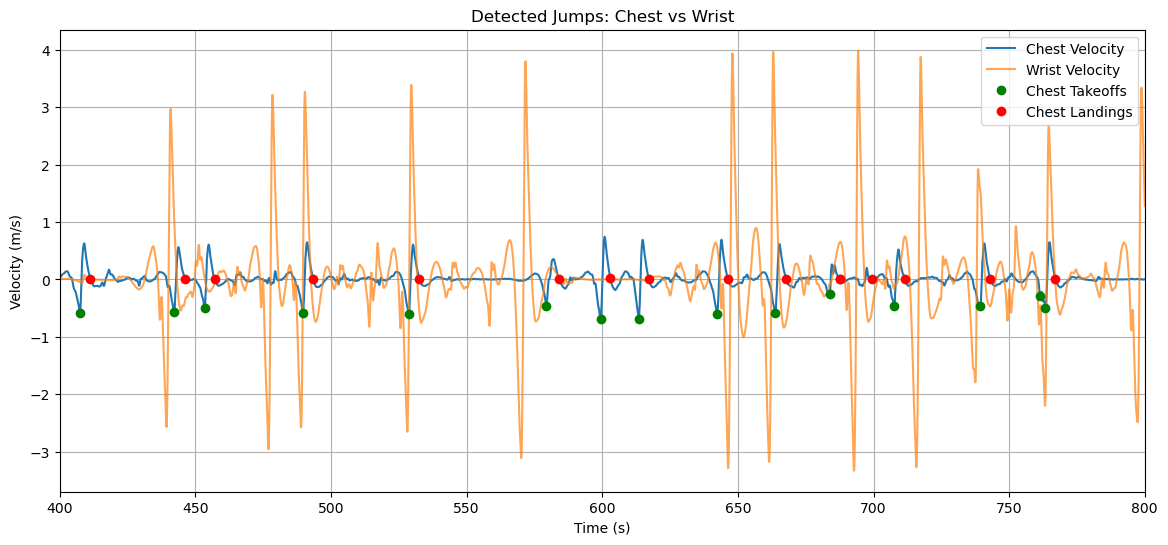

In [256]:
# plotting overlay
plt.figure(figsize=(14,6))
plt.plot(df_mad_jonatan_chest['time'], vel_corrected_ch, label="Chest Velocity")
plt.plot(df_mad_jonatan_wrist['time'], vel_corrected_wr, label="Wrist Velocity", alpha=0.7)

plt.plot(df_mad_jonatan_chest['time'].iloc[chest_jumps["takeoffs"]], 
         vel_corrected_ch[chest_jumps["takeoffs"]], "go", label="Chest Takeoffs")
plt.plot(df_mad_jonatan_chest['time'].iloc[chest_jumps["landings"]], 
         vel_corrected_ch[chest_jumps["landings"]], "ro", label="Chest Landings")
plt.xlim(400, 800)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.title("Detected Jumps: Chest vs Wrist")
plt.show()


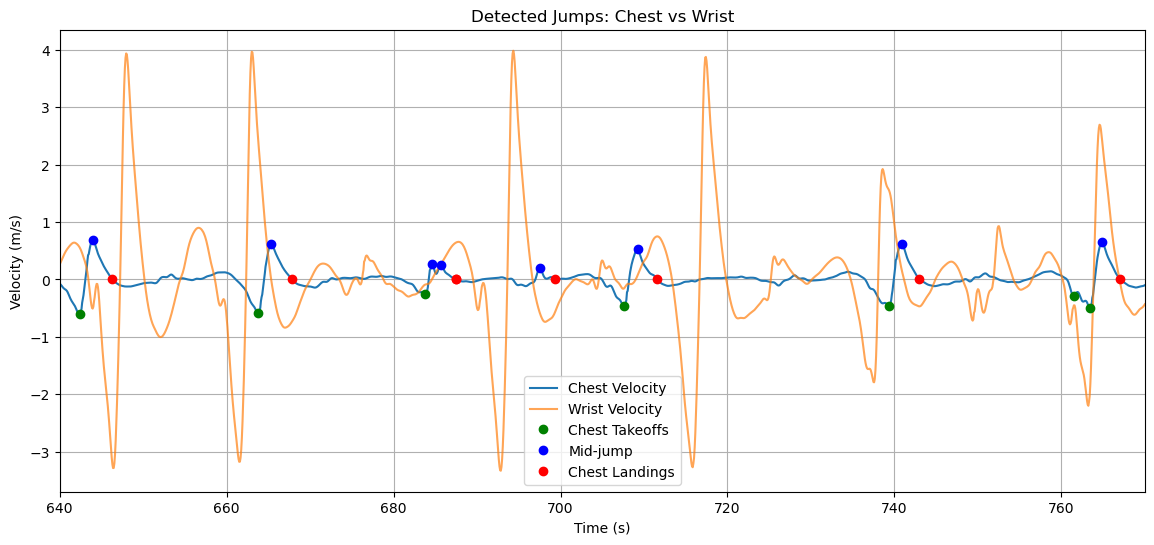

In [264]:
# plotting overlay
plt.figure(figsize=(14,6))
plt.plot(df_mad_jonatan_chest['time'], vel_corrected_ch, label="Chest Velocity")
plt.plot(df_mad_jonatan_wrist['time'], vel_corrected_wr, label="Wrist Velocity", alpha=0.7)

plt.plot(df_mad_jonatan_chest['time'].iloc[chest_jumps["takeoffs"]], 
         vel_corrected_ch[chest_jumps["takeoffs"]], "go", label="Chest Takeoffs")
plt.plot(df_mad_jonatan_chest['time'].iloc[chest_jumps["mid-jump"]], 
         vel_corrected_ch[chest_jumps["mid-jump"]], "bo", label="Mid-jump")
plt.plot(df_mad_jonatan_chest['time'].iloc[chest_jumps["landings"]], 
         vel_corrected_ch[chest_jumps["landings"]], "ro", label="Chest Landings")
plt.xlim(640, 770)
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.legend()
plt.grid(True)
plt.title("Detected Jumps: Chest vs Wrist")
plt.show()


### Identifying jumps

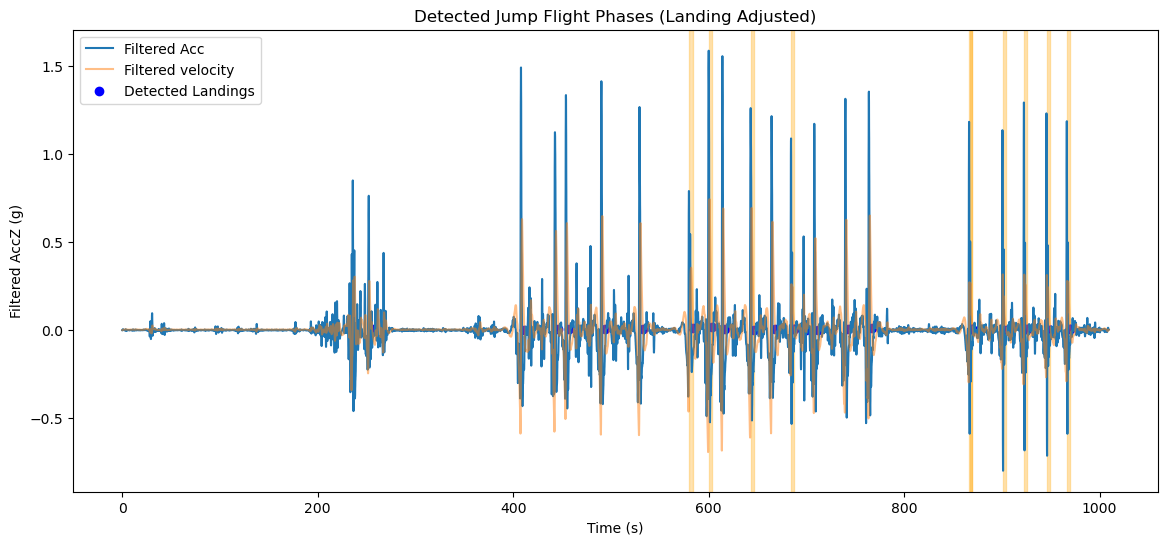

In [267]:
threshold = 0.5 # in g, threshold for detecting flight phase
min_duration = 0.2  # seconds
max_duration = 2.0  # seconds
min_samples = int(min_duration * estimated_hz)
max_samples = int(max_duration * estimated_hz)    

# Find where abs(filtered_acc_z) < threshold
flight_mask = np.abs(filtered_acc_ch) < threshold

# Find continuous regions (epochs) where flight_mask is True
from scipy.ndimage import label

labels, num = label(flight_mask) #
jump_epochs = []

# start and end indices of each epoch
for i in range(1, num+1):
    idx = np.where(labels == i)[0]
    if min_samples <= len(idx) <= max_samples:
        start_idx = idx[0]

        # instead of idx[-1], use nearest landing index *after* start
        landing_after_start = [li for li in chest_jumps["landings"] if li > start_idx]
        if landing_after_start:
            end_idx = landing_after_start[0]  # first detected landing
            jump_epochs.append((start_idx, end_idx))

# Mark jumps in DataFrame
df_mad_jonatan_chest['is_jump'] = 0
for start, end in jump_epochs:
    df_mad_jonatan_chest.iloc[start:end+1, df_mad_jonatan_chest.columns.get_loc('is_jump')] = 1


# plot detected flight phases
plt.figure(figsize=(14, 6))
plt.plot(df_mad_jonatan_chest['time'], filtered_acc_ch, label='Filtered Acc')
plt.plot(df_mad_jonatan_chest['time'], vel_corrected_ch, label='Filtered velocity', alpha=0.5)


for start, end in jump_epochs:
    plt.axvspan(df_mad_jonatan_chest['time'].iloc[start],
                df_mad_jonatan_chest['time'].iloc[end],
                color='orange', alpha=0.3)

plt.scatter(df_mad_jonatan_chest['time'].iloc[chest_jumps['landings']],
            vel_corrected_ch[chest_jumps['landings']],
            color='blue', label='Detected Landings')

plt.title('Detected Jump Flight Phases (Landing Adjusted)')
plt.xlabel('Time (s)')
plt.ylabel('Filtered AccZ (g)')
plt.legend()
plt.show()

In [268]:
#List of detected flight phases (start and end indices)
jump_epochs

[(np.int64(29469), np.int64(29675)),
 (np.int64(30514), np.int64(30635)),
 (np.int64(32703), np.int64(32835)),
 (np.int64(34773), np.int64(34927)),
 (np.int64(44029), np.int64(44195)),
 (np.int64(44051), np.int64(44195)),
 (np.int64(45763), np.int64(45935)),
 (np.int64(46880), np.int64(47043)),
 (np.int64(48052), np.int64(48231)),
 (np.int64(49109), np.int64(49271))]

In [269]:
# Calculate time in air for each detected jump using time between takeoff and landing peaks
jump_durations = []
for start, end in jump_epochs:
    time_in_air = df_mad_jonatan_chest['time'].iloc[end] - df_mad_jonatan_chest['time'].iloc[start]
    jump_durations.append(time_in_air)

# Print results
for i, duration in enumerate(jump_durations):
    print(f"Jump {i+1}: Time in air = {duration:.3f} seconds") 

Jump 1: Time in air = 4.016 seconds
Jump 2: Time in air = 2.363 seconds
Jump 3: Time in air = 2.599 seconds
Jump 4: Time in air = 2.992 seconds
Jump 5: Time in air = 3.228 seconds
Jump 6: Time in air = 2.835 seconds
Jump 7: Time in air = 3.386 seconds
Jump 8: Time in air = 3.149 seconds
Jump 9: Time in air = 3.465 seconds
Jump 10: Time in air = 3.151 seconds


## Calculate Jump height 

Jump 1: Estimated Jump Height = 19.777 m
Jump 2: Estimated Jump Height = 6.847 m
Jump 3: Estimated Jump Height = 8.283 m
Jump 4: Estimated Jump Height = 10.977 m
Jump 5: Estimated Jump Height = 12.778 m
Jump 6: Estimated Jump Height = 9.856 m
Jump 7: Estimated Jump Height = 14.059 m
Jump 8: Estimated Jump Height = 12.160 m
Jump 9: Estimated Jump Height = 14.723 m
Jump 10: Estimated Jump Height = 12.175 m


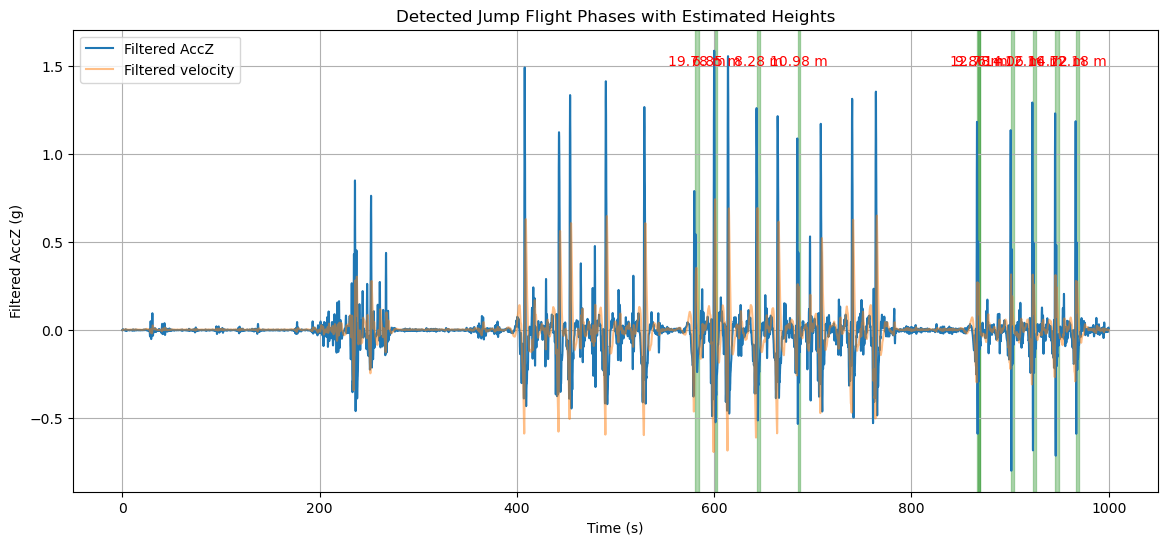

In [271]:
# Calculate Jump height from flight time
jump_heights = []
for duration in jump_durations:
    height = (duration**2) * 9.81 / 8  # in meters
    jump_heights.append(height)

# Print results
for i, height in enumerate(jump_heights):
    print(f"Jump {i+1}: Estimated Jump Height = {height:.3f} m")

# Midpoint time of each jump
jump_times = [
    (df_mad_jonatan_chest['time'].iloc[start] + df_mad_jonatan_chest['time'].iloc[end]) / 2
    for start, end in jump_epochs
]

# Create mask 
start_time = 0
end_time = 1000
mask = (df_mad_jonatan_chest['time'] >= start_time) & (df_mad_jonatan_chest['time'] <= end_time)

# Plot data in selected range with jump annotations
plt.figure(figsize=(14, 6))
plt.plot(df_mad_jonatan_chest['time'][mask], filtered_acc_ch[mask], label='Filtered AccZ')
plt.plot(df_mad_jonatan_chest['time'][mask], vel_corrected_ch[mask], label='Filtered velocity', alpha=0.5) 
for (start, end), height, time in zip(jump_epochs, jump_heights, jump_times):
    if start_time <= df_mad_jonatan_chest['time'].iloc[start] <= end_time:
        plt.axvspan(df_mad_jonatan_chest['time'].iloc[start],
                    df_mad_jonatan_chest['time'].iloc[end],
                    color='green', alpha=0.3)
        plt.text(time, 1.5, f"{height:.2f} m", color='red', ha='center')
plt.title('Detected Jump Flight Phases with Estimated Heights')
plt.xlabel('Time (s)')
plt.ylabel('Filtered AccZ (g)')
plt.legend()
plt.grid(True)
plt.show()

### Feature extraction

In [105]:
from scipy.stats import skew, kurtosis

# Window settings
window_size = int(estimated_hz * 2.0)  # 1 second
stride = int(estimated_hz * 0.25)      # 75% overlap

features = []
timestamps = []

for start in range(0, len(df_mad_jonatan_chest) - window_size, stride):
    end = start + window_size
    window = vel_corrected[start:end]

    ts = df_mad_jonatan_chest['time'].iloc[start]
    
    features.append([
        np.mean(window),
        np.std(window),
        np.max(window),
        np.min(window),
        np.ptp(window),            # Peak-to-peak
        np.argmax(window),         # Index of peak
        np.argmin(window),         # Index of trough
        skew(window),
        kurtosis(window),
        vel_corrected[start:end].mean()  # Average velocity in the window
    ])
    timestamps.append(ts)




In [106]:
# Create DataFrame
X = pd.DataFrame(features, columns=[
    'mean', 'std', 'max', 'min', 'ptp', 'argmax', 'argmin', 'skew', 'kurtosis', 'mean_velocity'
])


In [107]:
def is_in_jump_window(t, windows):
    for start, end in windows:
        if start <= t <= end:
            return 1
    return 0

y = [is_in_jump_window(t, jump_epochs) for t in timestamps]


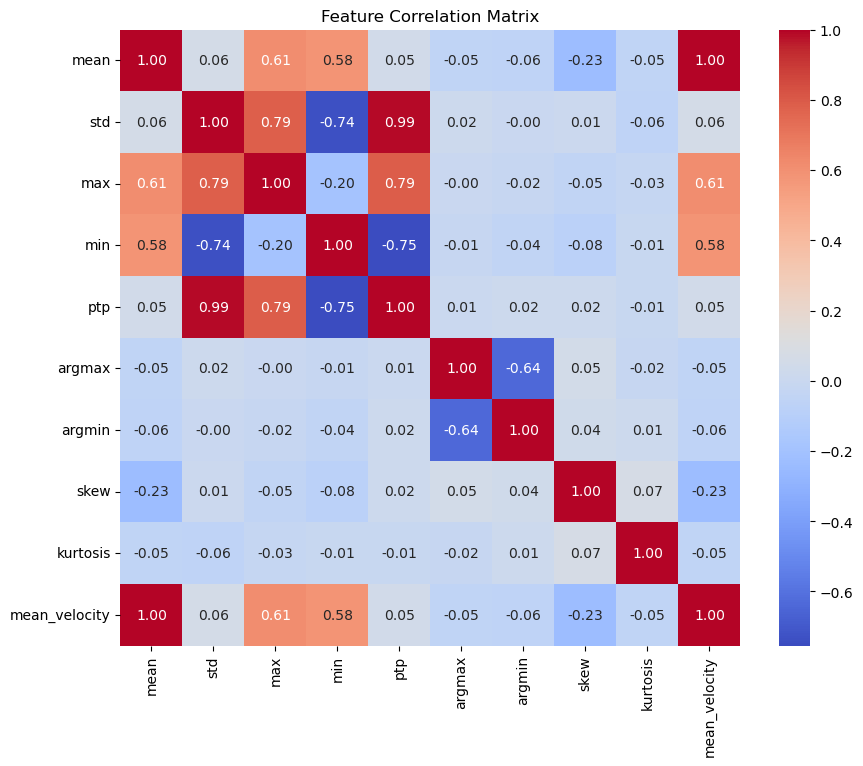

<Figure size 640x480 with 0 Axes>

In [108]:
# Feature correlation matrix
import seaborn as sns
plt.figure(figsize=(10, 8))
corr = X.corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()
plt.tight_layout()  

### Train a model

In [ ]:
#Train model

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix 

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [ ]:
# Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train) 

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False
